# **Regresión Dinámica Directa para doble péndulo**

In [320]:
import math
import numpy as np
import keras 
import tensorflow as tf
import datetime
import json
import os
#from tensorflow import keras
from keras.models import Sequential #One of the most important classes in tensorflow, used to creare NN (Named after NN as a sequence of layers)
from keras.layers import Input, Dense, LSTM, BatchNormalization, Dropout, InputLayer #Dense layer means that one neuron in one layer is connected to all neurons in the next layer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from keras.regularizers import l2, l1, l1_l2
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
from datetime import datetime

#tf.config.optimizer.set_jit(False)

#from keras_tuner import RandomSearch

In [321]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [322]:
model_name = "dp_backDyn_FF"     # val_loss=0.0016, 80 épocas, 50 mil muestras random
model_name = "dp_backDyn_FF_1"   # val_loss=0.0009, 171 épocas, 50 mil muestras random
fileNameScalers = f'/content/drive/My Drive/Colab Notebooks/{model_name}_scalers.pkl'
fileNameModel = f'/content/drive/My Drive/Colab Notebooks/{model_name}_.h5'

In [323]:
datos_2LRP_joint = pd.read_csv(f'./2lpr_jointmovement_2025_05_03-19_10_52.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
#datos_2LRP_cart = pd.read_csv(f'./2lpr_cartesianmovement_2024-10-03.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_cart = pd.read_csv(f'./2lpr_cartesianmovement_2025_05_05-22_50_57.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

In [324]:
time_joint = datos_2LRP_joint.iloc[:,1].values

pos_j1_joint = datos_2LRP_joint.iloc[:,2].values
pos_j2_joint = datos_2LRP_joint.iloc[:,3].values

vels_j1_joint = datos_2LRP_joint.iloc[:,4].values
vels_j2_joint = datos_2LRP_joint.iloc[:,5].values

accs_j1_joint = datos_2LRP_joint.iloc[:,6].values
accs_j2_joint = datos_2LRP_joint.iloc[:,7].values

torq_j1_joint = datos_2LRP_joint.iloc[:,8].values
torq_j2_joint = datos_2LRP_joint.iloc[:,9].values

In [325]:
time_cart = datos_2LRP_cart.iloc[:,1].values

pos_j1_cart = datos_2LRP_cart.iloc[:,2].values
pos_j2_cart = datos_2LRP_cart.iloc[:,3].values

vels_j1_cart = datos_2LRP_cart.iloc[:,4].values
vels_j2_cart = datos_2LRP_cart.iloc[:,5].values

accs_j1_cart = datos_2LRP_cart.iloc[:,6].values
accs_j2_cart = datos_2LRP_cart.iloc[:,7].values

torq_j1_cart = datos_2LRP_cart.iloc[:,8].values
torq_j2_cart = datos_2LRP_cart.iloc[:,9].values

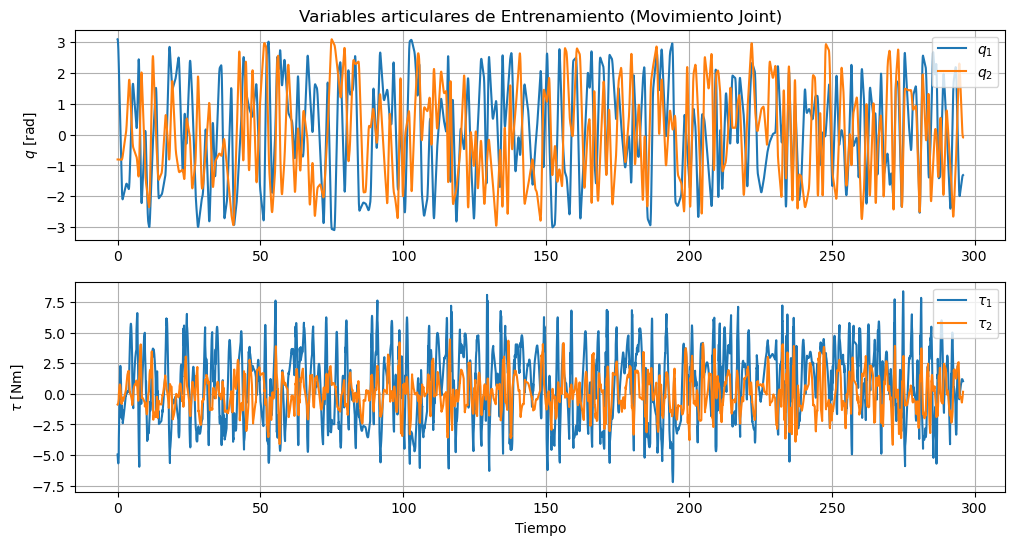

In [326]:
num_links = 2

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))  # Cambia el tamaño según tus necesidades
plt.subplot(2,1,1)
plt.plot(time_joint, pos_j1_joint)
plt.plot(time_joint, pos_j2_joint)
plt.legend([r'$q_1$', r'$q_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$q$ [rad]")
plt.grid(True)
plt.title('Variables articulares de Entrenamiento (Movimiento Joint)')
plt.subplot(2,1,2)
plt.plot(time_joint, torq_j1_joint)
plt.plot(time_joint, torq_j2_joint)
plt.legend([r'$\tau_{1}$', r'$\tau_{2}$'],loc='upper right', fontsize=10); plt.xlabel('Tiempo'); plt.ylabel(r"$\tau$ [Nm]")
plt.grid(True)
plt.show()

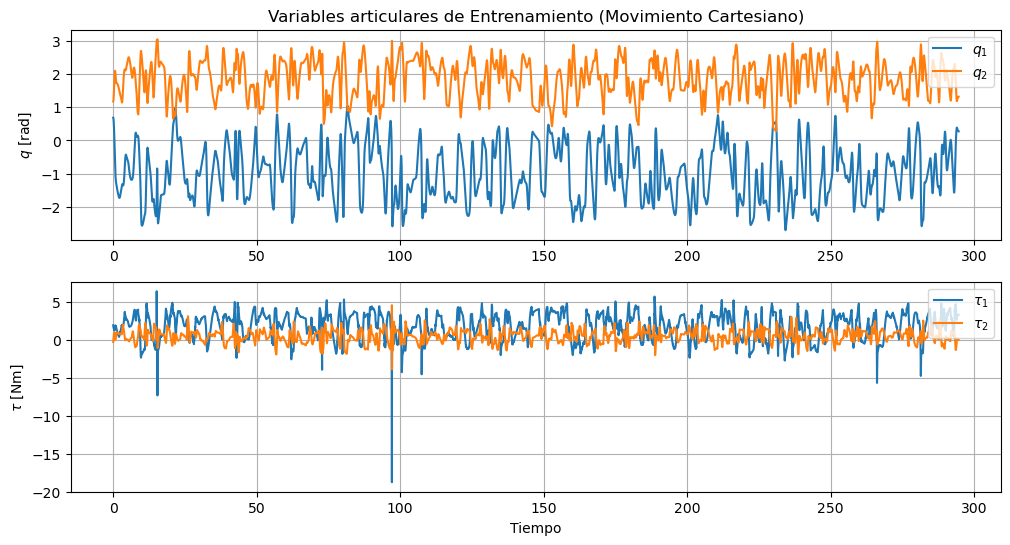

In [327]:
num_links = 2

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))  # Cambia el tamaño según tus necesidades
plt.subplot(2,1,1)
plt.plot(time_cart, pos_j1_cart)
plt.plot(time_cart, pos_j2_cart)
plt.legend([r'$q_1$', r'$q_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$q$ [rad]")
plt.grid(True)
plt.title('Variables articulares de Entrenamiento (Movimiento Cartesiano)')
plt.subplot(2,1,2)
plt.plot(time_cart, torq_j1_cart)
plt.plot(time_cart, torq_j2_cart)
plt.legend([r'$\tau_{1}$', r'$\tau_{2}$'],loc='upper right', fontsize=10); plt.xlabel('Tiempo'); plt.ylabel(r"$\tau$ [Nm]")
plt.grid(True)
plt.show()

# **Red neuronal Secuencial (Same-step approach)**:

No es el entrenamiento de las redes lo que se compara, sino la calidad de los resultados finales. Cada red tiene una técnica de entrenamiento: las secuenciales no aprenden la correlación entre muestras, entonces es mejor entrenarlas con muestras descorrelacionadas -> ruido blanco, en cambio, las redes LSTM aprenden la historia y evolución del sistema (la correlación entre muestras), van a necesitar muestras ordenadas, secuencia de tiempo.

Problema Dinámico INVERSO: Dados las posiciones, velocidades y aceleraciones joint, obtener el valor de los torques necesarios para mantener esa posición.

En el método de same step approach, tengo que tener en cuenta cómo se describe la fórmula a analizar. Para el problema inverso, tengo en cuenta que la expresión de la dinámica es una función contínua, pero todo refiere al mismo instante de tiempo, ya que dadas las posiciones, velocidades y aceleraciones, el valor de torque obtenido es aquel para mantener esta posición. Entonces los valores de posición y velocidad son para el instante de tiempo del torque resultante. 

Para el caso de la posición, no tiene sentido el same step approach, porque quiero calcular la posición siguiente

# **Red neuronal Secuencial (One-step-ahead approach)**

¿Es válido hacer un análisis One Step Ahead si el problema dinámico inverso se plantea como dadas las posiciones, velocidades y aceleraciones joint, obtener el valor de los torques necesarios para mantener esa posición?

Para el análisis con los datos randomizados, no tengo una secuencialidad de los datos ya que cada muestra es randomizada. Voy a probarlo con otro conjunto de muestras, pero inicialmente, creería que para resolver el problema dinámico no tiene sentido utilizar este método.

In [328]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time = datos_2LRP_joint.iloc[1:-1,1].values

pos_j1 = datos_2LRP_joint.iloc[:-2,2].values
pos_j2 = datos_2LRP_joint.iloc[:-2,3].values

vels_j1 = datos_2LRP_joint.iloc[:-2,4].values
vels_j2 = datos_2LRP_joint.iloc[:-2,5].values

accs_j1 = datos_2LRP_joint.iloc[1:-1,6].values
accs_j2 = datos_2LRP_joint.iloc[1:-1,7].values

torq_j1 = datos_2LRP_joint.iloc[1:-1,8].values
torq_j2 = datos_2LRP_joint.iloc[1:-1,9].values

next_pos_j1 = datos_2LRP_joint.iloc[1:-1,2].values
next_pos_j2 = datos_2LRP_joint.iloc[1:-1,3].values

In [329]:
inputs = np.vstack((pos_j1, pos_j2, torq_j1, torq_j2)).T
#outputs = np.vstack((accs_j1, accs_j2)).T
outputs = np.vstack((next_pos_j1, next_pos_j2)).T

In [330]:
X_train_OSA, X_test_OSA, y_train_OSA, y_test_OSA = train_test_split(inputs, outputs, test_size = 0.15)
X_train_OSA, X_val_OSA, y_train_OSA, y_val_OSA = train_test_split(X_train_OSA, y_train_OSA, test_size=0.15)

In [331]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_OSA = StandardScaler() #MinMaxScaler()
X_train_OSA = scaler1_OSA.fit_transform(X_train_OSA)#Primero se llama a la funcion fit para que ajuste los datos
X_test_OSA = scaler1_OSA.transform(X_test_OSA) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
X_val_OSA = scaler1_OSA.transform(X_val_OSA)

#Lo mismo para los outputs
scaler2_OSA = StandardScaler() #MinMaxScaler() #Otra forma de ESCALAR ---> scaler = StandardScaler()
y_train_OSA = scaler2_OSA.fit_transform(y_train_OSA)
y_test_OSA = scaler2_OSA.transform(y_test_OSA)
y_val_OSA = scaler2_OSA.transform(y_val_OSA)

In [332]:
print("X_train_OSA.shape: ", X_train_OSA.shape)
print("X_test_OSA.shape: ", X_test_OSA.shape)
print("X_val_OSA.shape: ", X_val_OSA.shape) 

X_train_OSA.shape:  (213787, 4)
X_test_OSA.shape:  (44386, 4)
X_val_OSA.shape:  (37728, 4)


🔄 Cargando modelo FF NN existente...


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 50)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,708 (34.02 KB)

 Trainable params: 2,902 (11.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,806 (22.68 KB)

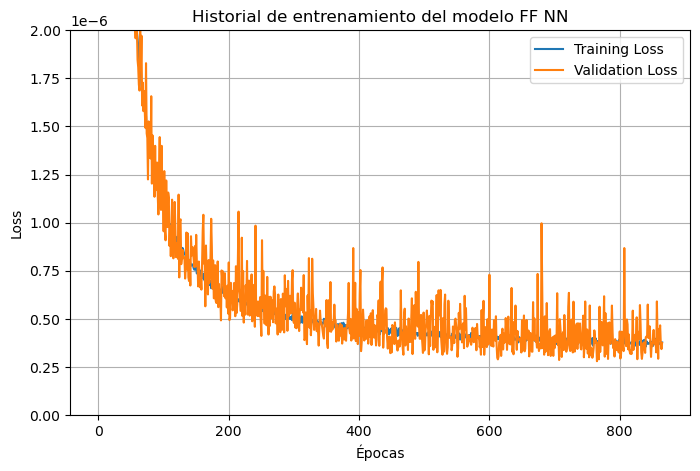

✅ Modelo FF NN listo para usar.


In [ ]:
# Verificar si el modelo ya existe

FF_NN_model_path = "./2LPR/DD_NN_Pos/Modelos_NN/FF_NN/ff_nn_OSA_Best_Model.keras"
FF_NN_history_path = "./2LPR/DD_NN_Pos/Modelos_NN/FF_NN/ff_nn_best_history.json"

if os.path.exists(FF_NN_model_path):
    print("🔄 Cargando modelo FF NN existente...")
    FF_NN_network = keras.models.load_model(FF_NN_model_path)
    FF_NN_network.summary()

    if os.path.exists(FF_NN_history_path):
        with open(FF_NN_history_path, "r") as f:
            FF_NN_history = json.load(f)  # Load the history data as a dictionary

        # Create a dummy History object for plotting:
        #FF_NN_history = type('DummyHistory', (object,), {'history': FF_NN_history_dict})()

        # Graficar el history
        plt.figure(figsize=(8, 5))
        plt.plot(FF_NN_history["loss"], label="Training Loss")
        plt.plot(FF_NN_history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.gca().set_ylim(0, 2e-6)
        plt.title("Historial de entrenamiento del modelo FF NN")
        plt.show()
    else:
        print("⚠️ No se encontró el archivo de history.")
else:
    print("⚙️ Creando nuevo modelo...")
    #Esta forma es lo más parecida posible al paper
    FF_NN_network = keras.models.Sequential([
        keras.layers.Dense(units=50, activation="tanh", input_shape=(inputs.shape[1],)),
        #keras.layers.Dense(100, activation="tanh"),
        keras.layers.Dense(50, activation="tanh"),
        keras.layers.Dense(2)
    ])
    FF_NN_network.summary()

    FF_NN_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
                          metrics = ['mae'])#Que pasa si uso SGD con learning rate


    checkpoint_cb = keras.callbacks.ModelCheckpoint(FF_NN_model_path, save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=100, min_delta=1e-10, restore_best_weights=True)
    
    FF_NN_history = FF_NN_network.fit(X_train_OSA, y_train_OSA, epochs=1000, 
                                      batch_size=300, validation_data=(X_val_OSA, y_val_OSA), 
                                      callbacks=[checkpoint_cb, early_stopping_cb])

    with open(FF_NN_history_path, "w") as f:
        json.dump(FF_NN_history.history, f)
    with open(FF_NN_history_path, "r") as f:
        FF_NN_history = json.load(f)  # Load the history data as a dictionary

    # Create a dummy History object for plotting:
    #FF_NN_history = type('DummyHistory', (object,), {'history': FF_NN_history_dict})()

    pd.DataFrame(FF_NN_history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 2e-6)
    plt.show()

print("✅ Modelo FF NN listo para usar.")

In [334]:
accuracy_test_OSA = FF_NN_network.evaluate(X_test_OSA, y_test_OSA)

1388/1388 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.7750e-07 - mae: 3.5644e-04


In [335]:
predictions_OSA = FF_NN_network.predict(X_test_OSA)

1388/1388 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [336]:
predictions_OSA[0]

array([-0.63105905, -1.7503501 ], dtype=float32)

In [337]:
y_test_OSA[0]

array([-0.63140375, -1.75049562])

In [338]:
predictions_OSA[:,0]

array([-0.63105905,  1.0283333 , -1.8028984 , ..., -1.2768826 ,
        0.36065486, -0.54767174], shape=(44386,), dtype=float32)

# **Red neuronal LSTM con Dataset JOINT**

In [339]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time = datos_2LRP_joint.iloc[1:-1,1].values

pos_j1 = datos_2LRP_joint.iloc[:-2,2].values
pos_j2 = datos_2LRP_joint.iloc[:-2,3].values

vels_j1 = datos_2LRP_joint.iloc[:-2,4].values
vels_j2 = datos_2LRP_joint.iloc[:-2,5].values

torq_j1 = datos_2LRP_joint.iloc[1:-1,8].values
torq_j2 = datos_2LRP_joint.iloc[1:-1,9].values

accs_j1 = datos_2LRP_joint.iloc[1:-1,6].values
accs_j2 = datos_2LRP_joint.iloc[1:-1,7].values

next_pos_j1 = datos_2LRP_joint.iloc[1:-1,2].values
next_pos_j2 = datos_2LRP_joint.iloc[1:-1,3].values

In [340]:
inputs = np.vstack((pos_j1, pos_j2, torq_j1, torq_j2)).T
#inputs = np.vstack((pos_j1, pos_j2, torq_j1, torq_j2)).T
outputs = np.vstack((next_pos_j1, next_pos_j2)).T

In [341]:
inputs.shape

(295901, 4)

In [342]:
def create_lstm_sequences(inputs, outputs, time_joint, window_size=6, split=0.8):
    """
    Genera secuencias de entrada y salida para una LSTM a partir de los datos de posición, velocidad, aceleración y torque.
    
    Args:
        inputs: Matriz de entrada que contiene las posiciones, velocidades y aceleraciones.
        outputs: Matriz de salida que contiene los torques.
        time_joint: Vector de tiempo asociado a los datos.
        window_size: Tamaño de la ventana de tiempo para la LSTM.
        split: Proporción del dataset que se utiliza para entrenamiento (el resto para prueba).
        
    Returns:
        X_train: Secuencias de entrada para entrenamiento.
        Y_train: Secuencias de salida para entrenamiento.
        X_test: Secuencias de entrada para prueba.
        Y_test: Secuencias de salida para prueba.
        t_test: Vector de tiempo correspondiente al conjunto de prueba.
    """
    # Preparar las secuencias de entrada y salida usando ventanas deslizantes
    input_sequences = []
    output_sequences = []
    
    for i in range(len(inputs) - window_size):
        input_sequences.append(inputs[i:i+window_size])
        output_sequences.append(outputs[i+window_size])
    
    # Convertir a arrays numpy
    X = np.array(input_sequences)
    Y = np.array(output_sequences)
    
    # Dividir en conjuntos de entrenamiento y prueba
    if split > 0 and split < 1:
        idx_split = int(split * len(X))
        X_train, X_test = X[:idx_split], X[idx_split:]
        Y_train, Y_test = Y[:idx_split], Y[idx_split:]
        t_test = time_joint[idx_split:-window_size-len(inputs)]
    else:
        X_train, X_test = X, None
        Y_train, Y_test = Y, None
        t_test = time_joint[:-window_size-len(inputs)]
    
    return X_train, Y_train, X_test, Y_test, t_test


In [343]:
#Para las LSTM es necesario que defin
# N_segments = 50 #Puntos destino de movimiento joint

# Definir el tamaño de la ventana de tiempo para las secuencias
w_size = 50

# Aplicar StandardScaler
scaler1_LSTM = StandardScaler() #MinMaxScaler()#feature_range=(0, 1)) #RobustScaler() #MinMaxScaler() #StandardScaler()
inputs = scaler1_LSTM.fit_transform(inputs)

scaler2_LSTM = StandardScaler() #MinMaxScaler()#feature_range=(0, 1)) #RobustScaler() #MinMaxScaler() #StandardScaler()
outputs = scaler2_LSTM.fit_transform(outputs)

X_train_LSTM, y_train_LSTM, X_test_LSTM, y_test_LSTM, t_test_LSTM  = create_lstm_sequences(inputs, outputs, time_joint, window_size=w_size, split=0.7)


In [344]:
X_train_LSTM.shape
#print(X_train_LSTM[0:4],y_train_LSTM[0:4])
print(X_train_LSTM.shape)
print(X_test_LSTM.shape)

(207095, 50, 4)
(88756, 50, 4)


🔄 Cargando modelo LSTM existente...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,868 (7.30 KB)

 Trainable params: 622 (2.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,246 (4.87 KB)

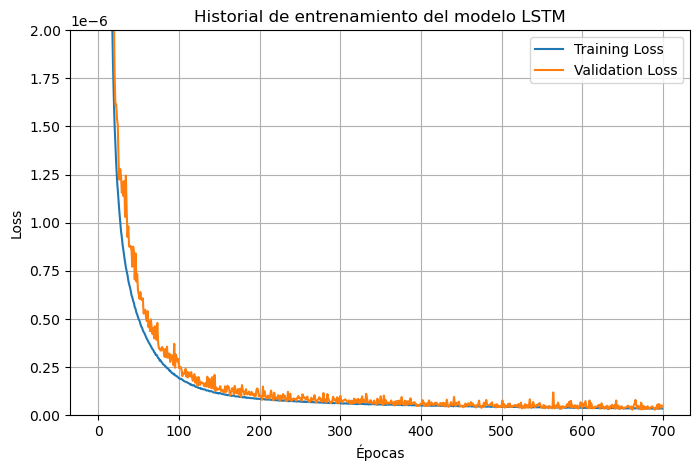

✅ Modelo LSTM listo para usar.


In [345]:
# Verificar si el modelo ya existe

LSTM_model_path = "./2LPR/DD_NN_Pos/Modelos_NN/LSTM/LSTM_nn_Best_Model.keras"
LSTM_history_path = "./2LPR/DD_NN_Pos/Modelos_NN/LSTM/lstm_best_history.json"

if os.path.exists(LSTM_model_path):
    print("🔄 Cargando modelo LSTM existente...")
    LSTM_network = keras.models.load_model(LSTM_model_path)
    LSTM_network.summary()

    if os.path.exists(LSTM_history_path):

        with open(LSTM_history_path, "r") as f:
            LSTM_history = json.load(f)  # Load the history data as a dictionary
        # Create a dummy History object for plotting:
        #LSTM_history = type('DummyHistory', (object,), {'history': LSTM_history_dict})()

        # Graficar el history
        plt.figure(figsize=(8, 5))
        plt.plot(LSTM_history["loss"], label="Training Loss")
        plt.plot(LSTM_history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.gca().set_ylim(0, 2e-6)
        plt.title("Historial de entrenamiento del modelo LSTM")
        plt.show()
    else:
        print("⚠️ No se encontró el archivo de history.")
else:
    print("⚙️ Creando nuevo modelo...")
    LSTM_network = Sequential() #Sequential([Input(shape=(w_size, X_train_LSTM.shape[2]))])
    LSTM_network.add(LSTM(10, activation='tanh', input_shape=(w_size, X_train_LSTM.shape[2])))
    
    #LSTM_network.add(LSTM(10, activation='tanh', input_shape=(w_size, X_train_LSTM.shape[2]), 
    #                return_sequences=True))
    #LSTM_network.add(LSTM(2, activation='tanh',
    #                return_sequences=True, kernel_regularizer=l2(0)))
    #LSTM_network.add(LSTM(10, activation='tanh'))
    LSTM_network.add(Dense(y_train_LSTM.shape[1]))
    LSTM_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(1e-4), metrics = ['mae']) #learning_rate=1e-5
    #mean_sqared_error
    LSTM_network.summary()


    #LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CT_p/Modelos_NN/LINEAR/LSTM_nn_Best_Model.h5", save_best_only=True)
    LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint(LSTM_model_path,save_best_only=True)
    LSTM_early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                           patience=100, min_delta=1E-10, 
                                                           restore_best_weights=True)

    LSTM_history = LSTM_network.fit(X_train_LSTM, y_train_LSTM, epochs=700, 
                                    batch_size=128, validation_data=(X_test_LSTM, y_test_LSTM), 
                                    callbacks=[LSTM_checkpoint_cb, LSTM_early_stopping_cb])
    
    with open(LSTM_history_path, "w") as f:
        json.dump(LSTM_history.history, f)
    with open(LSTM_history_path, "r") as f:
        LSTM_history = json.load(f)  # Load the history data as a dictionary

    # Create a dummy History object for plotting:
    #LSTM_history = type('DummyHistory', (object,), {'history': LSTM_history_dict})()

    pd.DataFrame(LSTM_history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 2e-6)
    plt.show()

print("✅ Modelo LSTM listo para usar.")

In [346]:
LSTM_accuracy_test = LSTM_network.evaluate(X_test_LSTM, y_test_LSTM)

2774/2774 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.9136e-08 - mae: 1.1220e-04


In [347]:
predictions_LSTM = LSTM_network.predict(X_test_LSTM)

2774/2774 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


In [348]:
predictions_LSTM[0]

array([-1.0537095,  1.223676 ], dtype=float32)

In [349]:
y_test_LSTM[0]

array([-1.05366249,  1.22386776])

# **Comparación de métricas de los modelos**

In [350]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que ya tienes los modelos entrenados y los datos de prueba para cada uno
# model1, model2 son los dos modelos entrenados
# X_test1, y_test1 son el conjunto de prueba del modelo 1
# X_test2, y_test2 son el conjunto de prueba del modelo 2

def compare_models(model1, model2, model1_name, model2_name, X_test1, y_test1, X_test2, y_test2):
    # Hacer predicciones para cada modelo en su propio conjunto de datos
    y_pred_model1 = model1.predict(X_test1)
    y_pred_model2 = model2.predict(X_test2)

    # Calcular métricas para model1 en su dataset
    mse_model1 = mean_squared_error(y_test1, y_pred_model1)
    mae_model1 = mean_absolute_error(y_test1, y_pred_model1)
    r2_model1 = r2_score(y_test1, y_pred_model1)

    # Calcular métricas para model2 en su dataset
    mse_model2 = mean_squared_error(y_test2, y_pred_model2)
    mae_model2 = mean_absolute_error(y_test2, y_pred_model2)
    r2_model2 = r2_score(y_test2, y_pred_model2)

    # Mostrar métricas para cada dataset
    print(f"Métricas del {model1_name} (Dataset 1):")
    print(f"MSE: {mse_model1:.10f}")
    print(f"MAE: {mae_model1:.10f}")
    print(f"R²: {r2_model1:.10f}")

    print(f"\nMétricas del {model2_name} (Dataset 2):")
    print(f"MSE: {mse_model2:.10f}")
    print(f"MAE: {mae_model2:.10f}")
    print(f"R²: {r2_model2:.10f}")

    # Opcional: Normalizar métricas (normalización simple usando el rango de los valores reales)
    range_y_test1 = np.max(y_test1) - np.min(y_test1)
    range_y_test2 = np.max(y_test2) - np.min(y_test2)

    mse_model1_normalized = mse_model1 / range_y_test1
    mse_model2_normalized = mse_model2 / range_y_test2

    print(f"\nMSE Normalizado para {model1_name}: {mse_model1_normalized:.10f}")
    print(f"MSE Normalizado para {model2_name}: {mse_model2_normalized:.10f}")

# Graficar curvas de pérdida durante el entrenamiento si tienes los históricos de entrenamiento
def plot_loss_curve(history1, model_name1, history2, model_name2):#,  history3, model_name3):
    plt.plot(history1['loss'], label=f'Pérdida Entrenamiento {model_name1}')
    plt.plot(history1['val_loss'], label=f'Pérdida Validación {model_name1}')
    plt.plot(history2['loss'], label=f'Pérdida Entrenamiento {model_name2}')
    plt.plot(history2['val_loss'], label=f'Pérdida Validación {model_name2}')
    #plt.plot(history3.history['loss'], label=f'Pérdida Entrenamiento {model_name3}')
    #plt.plot(history3.history['val_loss'], label=f'Pérdida Validación {model_name3}')
    plt.title('Curvas de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.gca().set_ylim(0, 0.01)
    plt.legend()
    plt.show()



1388/1388 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Métricas del Modelo FF (Dataset 1):
MSE: 0.0000002749
MAE: 0.0003541204
R²: 0.9999997242

Métricas del Modelo LSTM (Dataset 2):
MSE: 0.0000000284
MAE: 0.0001094449
R²: 0.9999999691

MSE Normalizado para Modelo FF: 0.0000000638
MSE Normalizado para Modelo LSTM: 0.0000000071


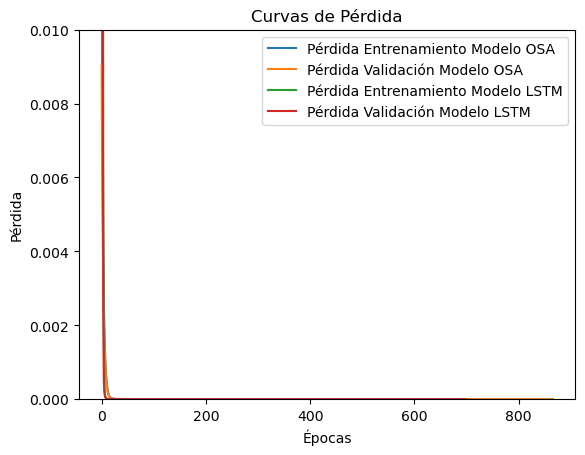

In [351]:
compare_models(FF_NN_network, LSTM_network,'Modelo FF', 'Modelo LSTM', X_test_OSA, y_test_OSA, X_test_LSTM, y_test_LSTM)
plot_loss_curve(FF_NN_history, 'Modelo OSA', LSTM_history, 'Modelo LSTM')

# **Verificación con otro conjunto de datos**

In [352]:
#Uso el otro dataset joint

datos_2LRP_ref_joint = pd.read_csv(f'./2lpr_jointmovement_2024-10-03.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

#datos_2LRP_ref_joint.head()
t_ref = datos_2LRP_ref_joint.iloc[1:-1,1].values

q1_ref = datos_2LRP_ref_joint.iloc[:-2,2].values
q2_ref = datos_2LRP_ref_joint.iloc[:-2,3].values

dq1_ref = datos_2LRP_ref_joint.iloc[:-2,4].values
dq2_ref = datos_2LRP_ref_joint.iloc[:-2,5].values

ddq1_ref = datos_2LRP_ref_joint.iloc[1:-1,6].values
ddq2_ref = datos_2LRP_ref_joint.iloc[1:-1,7].values

t1_ref = datos_2LRP_ref_joint.iloc[1:-1,8].values
t2_ref = datos_2LRP_ref_joint.iloc[1:-1,9].values

next_q1_ref = datos_2LRP_ref_joint.iloc[1:-1,2].values
next_q2_ref = datos_2LRP_ref_joint.iloc[1:-1,3].values

datos_2LRP_ref_joint.head()

ID   Time   Theta_1   Theta_2  D_Theta_1  D_Theta_2  DD_Theta_1  \
0   1  0.000 -1.926178 -1.430799   0.001258   0.004265    1.257762   
1   2  0.001 -1.926176 -1.430793   0.002516   0.008531    1.257762   
2   3  0.002 -1.926173 -1.430782   0.003773   0.012796    1.257762   
3   4  0.003 -1.926168 -1.430767   0.005031   0.017062    1.257762   
4   5  0.004 -1.926163 -1.430748   0.006289   0.021327    1.257762   

   DD_Theta_2  Torque_1  Torque_2  
0    4.265447 -2.000074 -0.890958  
1    4.265447 -1.999438 -0.888827  
2    4.265447 -1.998798 -0.886697  
3    4.265447 -1.998153 -0.884568  
4    4.265447 -1.997503 -0.882441

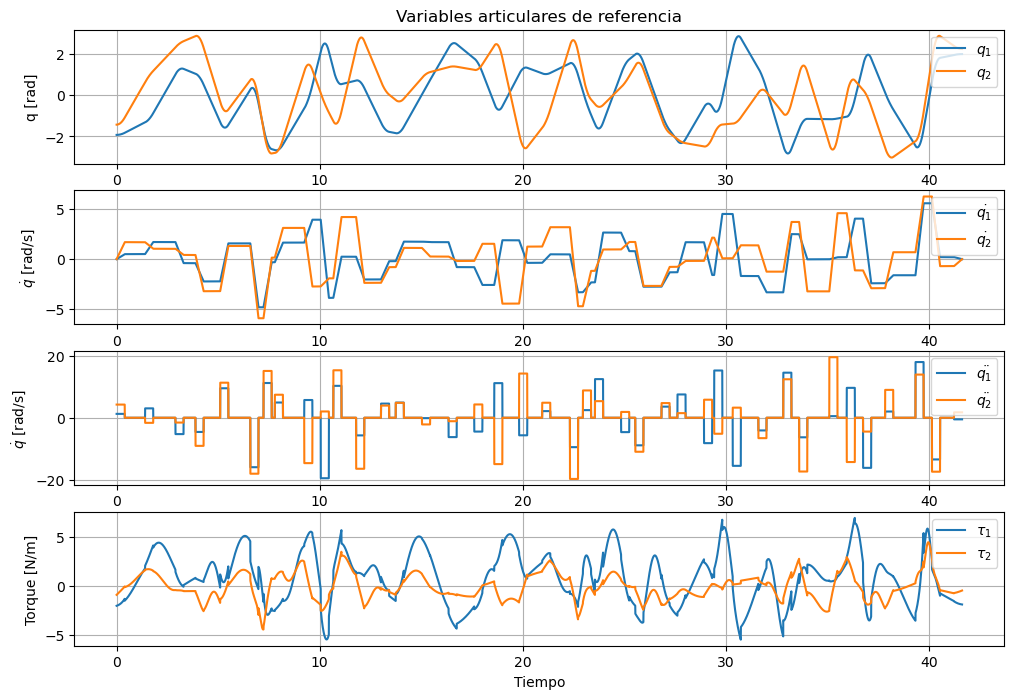

In [353]:
num_links = 2

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades
plt.subplot(4,1,1)
plt.plot(t_ref, q1_ref)
plt.plot(t_ref, q2_ref)
plt.legend([r'$q_1$', r'$q_2$'],loc='upper right', fontsize=10);  plt.ylabel(r'q [rad]')
plt.grid(True)
plt.title('Variables articulares de referencia')
plt.subplot(4,1,2)
plt.plot(t_ref, dq1_ref)
plt.plot(t_ref, dq2_ref)
plt.legend([r'$\dot{q_{1}}$', r'$\dot{q_{2}}$'],loc='upper right', fontsize=10);  plt.ylabel(r'$\dot{q}$ [rad/s]')
plt.grid(True)
plt.subplot(4,1,3)
plt.plot(t_ref, ddq1_ref)
plt.plot(t_ref, ddq2_ref)
plt.legend([r'$\ddot{q_{1}}$', r'$\ddot{q_{2}}$'],loc='upper right', fontsize=10);  plt.ylabel(r'$\dot{q}$ [rad/s]')
plt.grid(True)
plt.subplot(4,1,4)
plt.plot(t_ref, t1_ref)
plt.plot(t_ref, t2_ref)
plt.legend([r'$\tau_{1}$', r'$\tau_{2}$'],loc='upper right', fontsize=10); plt.xlabel('Tiempo'); plt.ylabel('Torque [N/m]')
plt.grid(True)
plt.show()


In [354]:
inputs_ref = np.vstack((q1_ref,q2_ref,t1_ref,t2_ref)).T
inputs_ref_LSTM = np.vstack((q1_ref,q2_ref,t1_ref,t2_ref)).T
outputs_ref = np.vstack((next_q1_ref,next_q2_ref)).T

In [355]:
#Primero con FF NN

X_test_scaled_FF_NN = scaler1_OSA.transform(inputs_ref)
q_sim_FF_NN = scaler2_OSA.inverse_transform(FF_NN_network.predict(X_test_scaled_FF_NN))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step


In [356]:
def create_sequences_with_time(data, time, window_size= w_size):
    sequences = []
    times = []
    
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size]
        sequences.append(sequence)
        
        # Alinear con el tiempo del último dato de la ventana
        time_point = time[i + window_size - 1]
        times.append(time_point)
    
    return np.array(sequences), np.array(times)

w_size = 50
X_test_scaled_LSTM = scaler1_LSTM.transform(inputs_ref_LSTM)
X_test_windowed_LSTM, t_ref_LSTM = create_sequences_with_time(X_test_scaled_LSTM, t_ref)
q_sim_LSTM = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM))

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


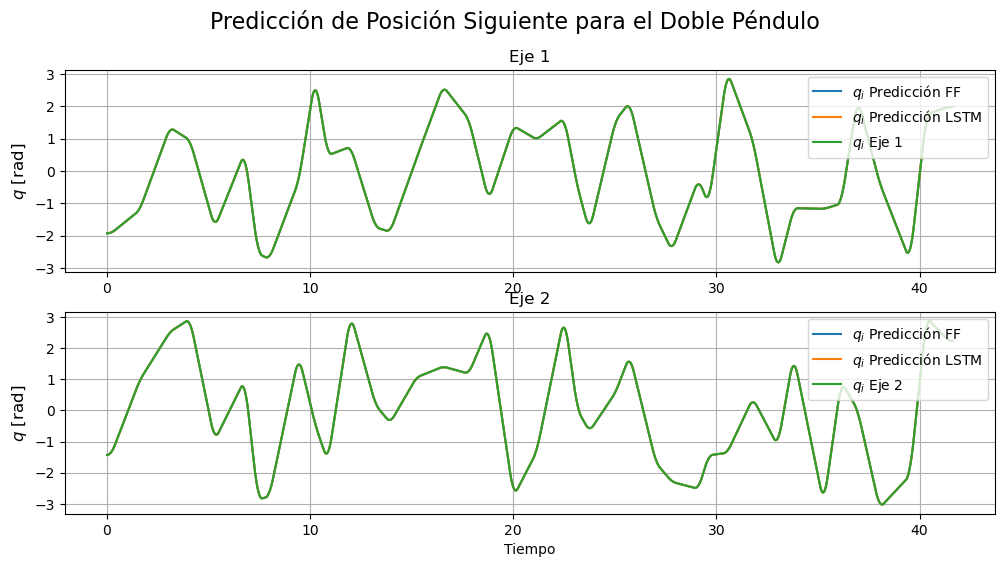

In [357]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Predicción de Posición Siguiente para el Doble Péndulo", fontsize=16, y=0.95)

# Grafico los resultados
for i in range(num_links):
  plt.subplot(num_links, 1, i+1)
  plt.plot(t_ref,q_sim_FF_NN[:,i])
  plt.plot(t_ref_LSTM,q_sim_LSTM[:,i])
  plt.plot(t_ref,outputs_ref[:,i])
  plt.ylabel(r'$q$ [rad]', fontsize=12)
  plt.legend([r"$q_{i}$ Predicción FF", r"$q_{i}$ Predicción LSTM", r"$q_{i}$ " f'Eje {i+1}'],loc='upper right', 
             fontsize=10)
  #plt.gca().set_xlim(0, 0.1)
  #plt.gca().set_ylim(-1.45, -1.4)
  plt.title(f'Eje {i+1}', fontsize=12)
  plt.grid(True)

plt.subplots_adjust(top=0.85)  
plt.xlabel('Tiempo');
plt.show()


0.004342469396780402
0.001959249186680445
0.0017611524379779198
0.002307266713533762


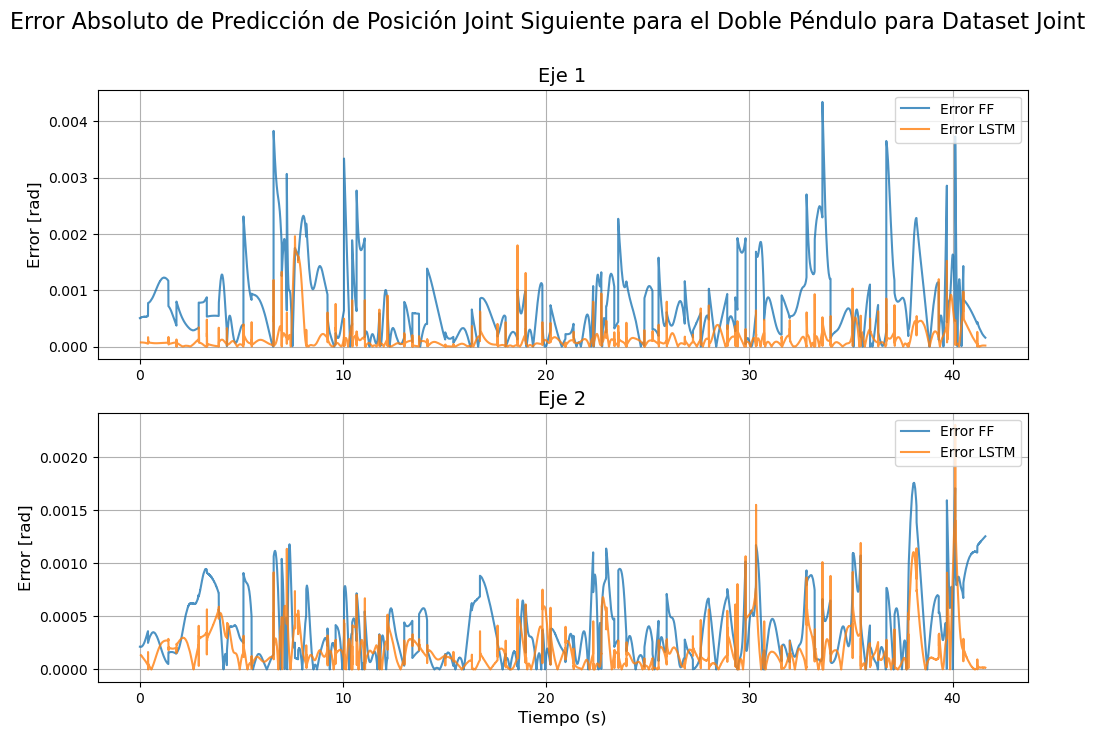

In [358]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error Absoluto de Predicción de Posición Joint Siguiente para el Doble Péndulo para Dataset Joint", 
             fontsize=16,  y=0.95)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    #error_OSA_Joint_j = np.sqrt((q_sim_FF_NN[:, i] - outputs_ref[:, i])**2)
    #error_LSTM_Joint_j = np.sqrt((q_sim_LSTM[:-1, i] - outputs_ref[w_size:, i])**2)
    # Cálculo del error absoluto
    error_LSTM_Joint_j = np.abs(q_sim_LSTM[:, i] - outputs_ref[w_size:, i])
    error_OSA_Joint_j = np.abs(q_sim_FF_NN[:, i] - outputs_ref[:, i])

    print(max(error_OSA_Joint_j))
    print(max(error_LSTM_Joint_j))
    
    # Graficar los errores
    #plt.plot(t_ref, error_OSA_Joint_j, label='Error SS Joint')
    #plt.plot(t_ref_LSTM[:], error_LSTM_Joint_j, label='Error LSTM Joint')    
    plt.plot(t_ref[:], error_OSA_Joint_j, label='Error FF', alpha=0.8)
    plt.plot(t_ref[w_size:], error_LSTM_Joint_j, label='Error LSTM', alpha=0.8)
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel(r'Error [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

plt.subplots_adjust(top=0.85)  

# Ajustar los espacios entre subplots
#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()



# **Reconstrucción de las señales (Velocidad y Aceleración)**

A partir de las estimaciones encontradas, creo una función que pueda llamar y guardar las estimaciones, como también las velocidades y aceleraciones reconstuidas.

In [359]:
q_sim_LSTM.shape

(41566, 2)

In [360]:
q_ref = np.vstack((q1_ref, q2_ref)).T  # Forzar matriz válida
dq_ref = np.vstack((dq1_ref, dq2_ref)).T  # Forzar matriz válida
ddq_ref = np.vstack((ddq1_ref, ddq2_ref)).T  # Forzar matriz válida
tau_ref = np.vstack((t1_ref, t2_ref)).T 
dq_ref[:,1]

array([ 0.00426545,  0.00853089,  0.01279634, ..., -0.00703047,
       -0.00527285, -0.00351523], shape=(41616,))

In [361]:
def reconstruir_dinamica(t, q_est, metodo="diferencias", sigma=10):
    """
    Reconstruye la velocidad y la aceleración a partir de posiciones estimadas y el vector de tiempo.
    
    Parámetros:
        t (numpy array): Vector de tiempo.
        q_est (numpy array): Posiciones estimadas.
        metodo (str): Método a utilizar ("diferencias", "savgol", "spline").
        window_length (int): Tamaño de la ventana para Savitzky-Golay (debe ser impar).
        polyorder (int): Orden del polinomio para Savitzky-Golay.
        h (float): Paso de tiempo si no se proporciona `t`.
        spline_smooth (float): Parámetro de suavizado para el spline (mayor valor = más suavizado).
        
    Retorna:
        qd_est (numpy array): Velocidad estimada.
        qdd_est (numpy array): Aceleración estimada.
    """
  
    # Convertir a arreglos de NumPy
    t = np.asarray(t)
    q_est = np.asarray(q_est)

    # Verificar que t y q_est tengan la misma longitud
    if len(t) != len(q_est):
        raise ValueError("Los vectores t y q_est deben tener la misma longitud.")

    if metodo == "diferencias":
        qd_est = np.gradient(q_est, t, axis=0)  
        qd_est = np.array([gaussian_filter1d(qd_est[:, i], sigma) for i in range(qd_est.shape[1])]).T
        qdd_est = np.gradient(qd_est, t, axis=0)

    elif metodo == "spline":
        # Crear un spline cúbico con suavizado
        #spline = CubicSpline(t, q_est, bc_type='natural')
        qd_est = CubicSpline(t, q_est, bc_type='natural').derivative()(t)
        qd_est = np.array([gaussian_filter1d(qd_est[:, i], sigma) for i in range(qd_est.shape[1])]).T
        qdd_est = CubicSpline(t, qd_est).derivative(1)(t)


    else:
        raise ValueError("Método no reconocido. Use 'diferencias' o 'spline'.")

    return qd_est, qdd_est


In [362]:
qd_spline_2, qdd_spline_2 = reconstruir_dinamica(t_ref_LSTM, q_sim_LSTM, metodo="spline")
qd_diff_2, qdd_diff_2 = reconstruir_dinamica(t_ref_LSTM, q_sim_LSTM, metodo="diferencias")

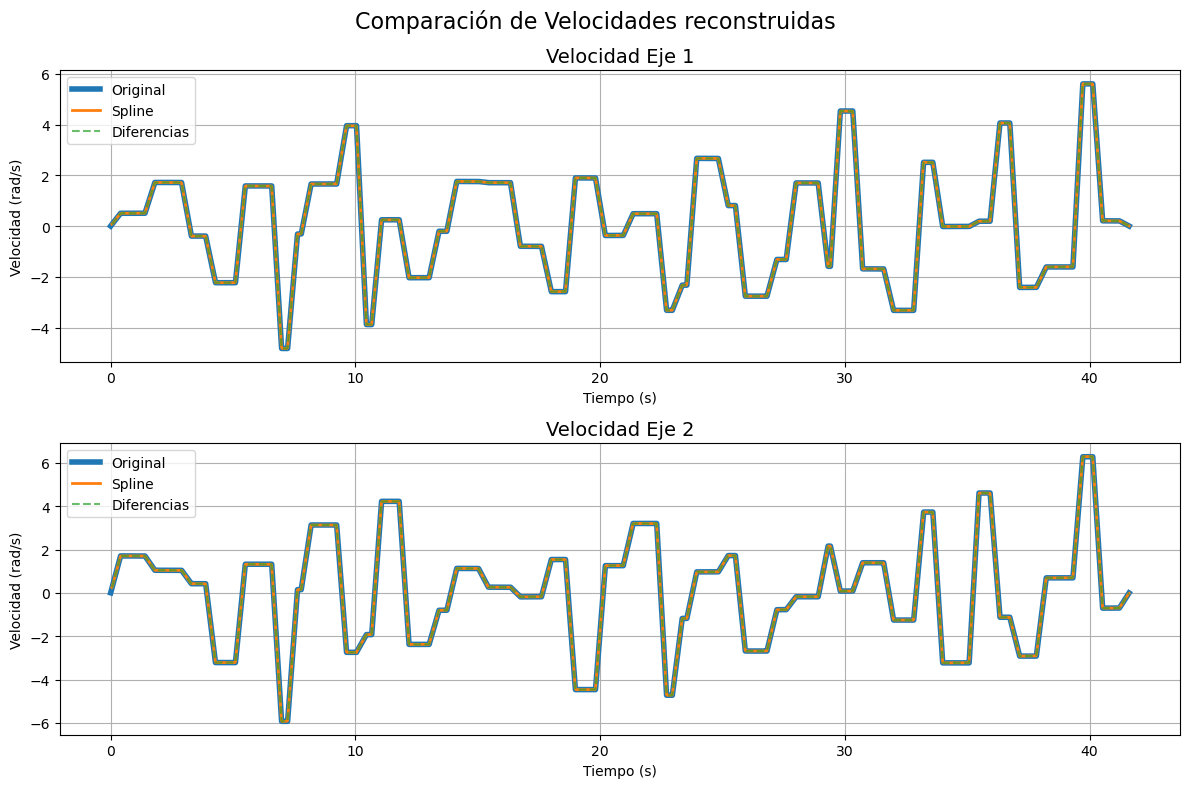

In [363]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Velocidades reconstruidas", fontsize=16)

for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    # Velocidad - Comparación spline vs diferencias
    plt.plot(t_ref, dq_ref[:,i], label="Original", linewidth=4)
    plt.plot(t_ref_LSTM, qd_spline_2[:,i], label="Spline", linewidth=2)
    plt.plot(t_ref_LSTM[:], qd_diff_2[:,i], linestyle="dashed", label="Diferencias", alpha=0.7)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Velocidad (rad/s)")
    plt.title(f'Velocidad Eje {i+1}', fontsize=14)
    plt.legend()
    plt.ylim
    plt.grid()

plt.tight_layout()
plt.show()

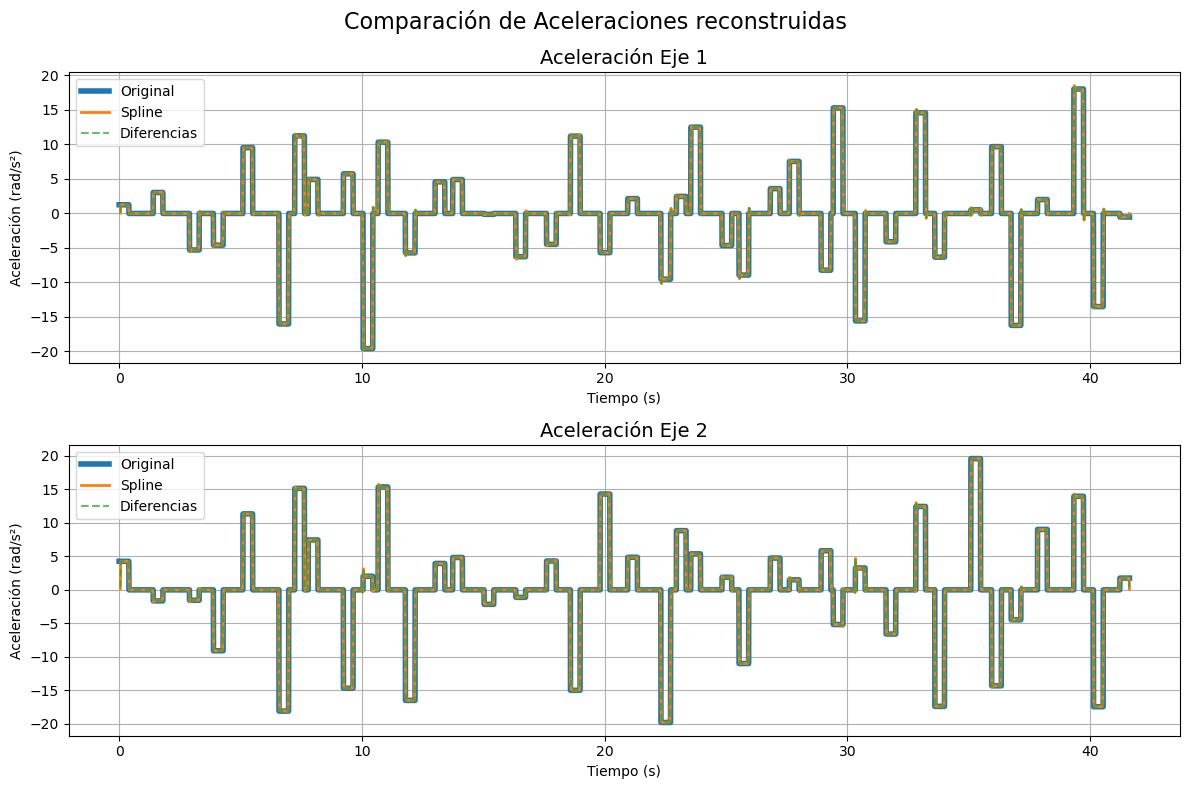

In [364]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Aceleraciones reconstruidas", fontsize=16)

for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)


# Aceleración - Comparación spline vs diferencias
    plt.plot(t_ref, ddq_ref[:,i], label="Original", linewidth=4)
    plt.plot(t_ref_LSTM, qdd_spline_2[:,i], label="Spline", linewidth=2)
    plt.plot(t_ref_LSTM[:], qdd_diff_2[:,i], linestyle="dashed", label="Diferencias", alpha=0.7)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Aceleración (rad/s²)")
    plt.title(f'Aceleración Eje {i+1}', fontsize=14)
    plt.legend()
    plt.grid()


plt.tight_layout()
plt.show()

In [365]:
def write_noise_data_to_csv(file_name, t_ref, q_ref, qd_ref, qdd_ref, tau_ref, q_ref_noise, qd_ref_noise, qdd_ref_noise):
    fecha_actual = datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
    directory = './2LPR/DD_NN_Pos/DATA/'
    filename = f'{directory}{file_name}_{fecha_actual}.csv'

    # Crear el directorio si no existe
    os.makedirs(directory, exist_ok=True)

    cantidad = len(t_ref)

    if not os.path.isfile(filename) or os.path.getsize(filename) == 0:
        # Si el archivo no existe o está vacío, escribir las cabeceras CSV
        with open(filename, 'w') as archivo:
            archivo.write('ID, Time, Theta_1, Theta_2, D_Theta_1, D_Theta_2, DD_Theta_1, DD_Theta_2, Torque_1, Torque_2, Theta_N_1, Theta_N_2, D_Theta_N_1, D_Theta_N_2, DD_Theta_N_1, DD_Theta_N_2\n')
    with open(filename, 'a') as archivo:
        for _ in range(cantidad):
            id = _ +1
            time = t_ref[_]
            j_1 = q_ref[_][0]
            j_2 = q_ref[_][1]
            d_j_1 = qd_ref[_][0]
            d_j_2 = qd_ref[_][1]
            dd_j_1 = qdd_ref[_][0]
            dd_j_2 = qdd_ref[_][1]
            tau_1 = tau_ref[_][0]
            tau_2 = tau_ref[_][1]
            j_1_noise = q_ref_noise[_][0]
            j_2_noise = q_ref_noise[_][1]
            d_j_1_noise = qd_ref_noise[_][0]
            d_j_2_noise = qd_ref_noise[_][1]
            dd_j_1_noise = qdd_ref_noise[_][0]
            dd_j_2_noise = qdd_ref_noise[_][1]

            archivo.write(f'{id}, {time}, {j_1}, {j_2}, {d_j_1}, {d_j_2}, {dd_j_1}, {dd_j_2}, {tau_1}, {tau_2}, {j_1_noise}, {j_2_noise}, {d_j_1_noise}, {d_j_2_noise}, {dd_j_1_noise}, {dd_j_2_noise}\n')

In [366]:
#q_ref = np.vstack((q1_ref, q2_ref)).T  
#dq_ref = np.vstack((dq1_ref, dq2_ref)).T  
#ddq_ref = np.vstack((ddq1_ref, ddq2_ref)).T  
tau_ref = np.vstack((t1_ref, t2_ref)).T 

file_name = 'Reconstruccion_2lpr_jointmovement'
write_noise_data_to_csv(file_name, t_ref_LSTM, q_ref, dq_ref, ddq_ref, tau_ref, q_sim_LSTM, qd_spline_2, qdd_spline_2)

# **Comparación de conjunto de Datos, Cartesiano vs Joint**

Para la comparación entre el conjunto de datos Cartesiano vs Joint, voy a crear otras redes neuronales FF y LSTM con las mismas características que las anteriores, entrenándolas exclusivamente con datasets cartesianos, y se compara la estimación de las 4 redes utilizando un nuevo conjunto joint y un nuevo conjunto cartesiano.

In [367]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time_cart = datos_2LRP_cart.iloc[1:-1,1].values

pos_j1_cart = datos_2LRP_cart.iloc[:-2,2].values
pos_j2_cart = datos_2LRP_cart.iloc[:-2,3].values

vels_j1_cart = datos_2LRP_cart.iloc[:-2,4].values
vels_j2_cart = datos_2LRP_cart.iloc[:-2,5].values

accs_j1_cart = datos_2LRP_cart.iloc[1:-1,6].values
accs_j2_cart = datos_2LRP_cart.iloc[1:-1,7].values

torq_j1_cart = datos_2LRP_cart.iloc[1:-1,8].values
torq_j2_cart = datos_2LRP_cart.iloc[1:-1,9].values

next_pos_j1_cart = datos_2LRP_cart.iloc[1:-1,2].values
next_pos_j2_cart = datos_2LRP_cart.iloc[1:-1,3].values

# Empiezo por el caso FeedForward

In [368]:
inputs_cart = np.vstack((pos_j1_cart, pos_j2_cart, torq_j1_cart, torq_j2_cart)).T
outputs_cart = np.vstack((next_pos_j1_cart,next_pos_j2_cart)).T

In [369]:
#Preparo los datos para la red FF
X_train_FF_cart, X_test_FF_cart, y_train_FF_cart, y_test_FF_cart = train_test_split(inputs_cart, outputs_cart, test_size = 0.15)
X_train_FF_cart, X_val_FF_cart, y_train_FF_cart, y_val_FF_cart = train_test_split(X_train_FF_cart, y_train_FF_cart, test_size=0.15)

In [370]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_FF_cart = StandardScaler()
X_train_FF_cart = scaler1_FF_cart.fit_transform(X_train_FF_cart)#Primero se llama a la funcion fit para que ajuste los datos
X_test_FF_cart = scaler1_FF_cart.transform(X_test_FF_cart) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
X_val_FF_cart = scaler1_FF_cart.transform(X_val_FF_cart)

#Lo mismo para los outputs
scaler2_FF_cart = StandardScaler() #Otra forma de ESCALAR ---> scaler = StandardScaler()
y_train_FF_cart = scaler2_FF_cart.fit_transform(y_train_FF_cart)
y_test_FF_cart = scaler2_FF_cart.transform(y_test_FF_cart)
y_val_FF_cart = scaler2_FF_cart.transform(y_val_FF_cart)

🔄 Cargando modelo FF NN (CARTESIANO) existente...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,708 (34.02 KB)

 Trainable params: 2,902 (11.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,806 (22.68 KB)

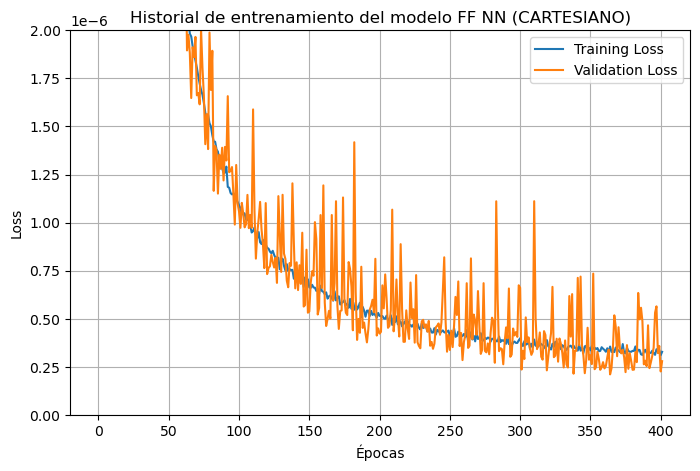

✅ Modelo FF NN (CARTESIANO) listo para usar.


In [371]:
# Verificar si el modelo ya existe

FF_NN_cart_model_path = "./2LPR/DD_NN_Pos/Modelos_NN/FF_NN_cart/FF_NN_nn_Best_Model.keras"
FF_NN_cart_history_path = "./2LPR/DD_NN_Pos/Modelos_NN/FF_NN_cart/ff_nn_best_history.json"

if os.path.exists(FF_NN_cart_model_path):
    print("🔄 Cargando modelo FF NN (CARTESIANO) existente...")
    FF_NN_cart_network = keras.models.load_model(FF_NN_cart_model_path)
    FF_NN_cart_network.summary()

    if os.path.exists(FF_NN_cart_history_path):
        with open(FF_NN_cart_history_path, "r") as f:
            FF_NN_cart_history = json.load(f)
        with open(FF_NN_cart_history_path, "r") as f:
            FF_NN_cart_history = json.load(f)  # Load the history data as a dictionary

        # Create a dummy History object for plotting:
        #FF_NN_cart_history = type('DummyHistory', (object,), {'history': FF_NN_cart_history_dict})()

        # Graficar el history
        plt.figure(figsize=(8, 5))
        plt.plot(FF_NN_cart_history["loss"], label="Training Loss")
        plt.plot(FF_NN_cart_history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.gca().set_ylim(0, 2e-6)
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Historial de entrenamiento del modelo FF NN (CARTESIANO)")
        plt.show()
    else:
        print("⚠️ No se encontró el archivo de history.")
else:
    print("⚙️ Creando nuevo modelo...")
    #Esta forma es lo más parecida posible al paper
    FF_NN_cart_network = keras.models.Sequential([
        keras.layers.Dense(units=50, activation="tanh", input_shape=(inputs_cart.shape[1],)),
        #keras.layers.Dense(100, activation="tanh"),
        keras.layers.Dense(50, activation="tanh"),
        keras.layers.Dense(2)
    ])
    FF_NN_cart_network.summary()

    FF_NN_cart_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(1e-4), metrics = ['mae'])

    checkpoint_cb_cart = keras.callbacks.ModelCheckpoint(FF_NN_cart_model_path, save_best_only=True)
    early_stopping_cb_cart = keras.callbacks.EarlyStopping(patience=100, min_delta=1e-7, restore_best_weights=True)
    
    FF_NN_cart_history = FF_NN_cart_network.fit(X_train_FF_cart, y_train_FF_cart, batch_size=300, 
                                                epochs=1000, validation_data=(X_val_FF_cart, y_val_FF_cart), 
                                                callbacks=[checkpoint_cb_cart, early_stopping_cb_cart])
    with open(FF_NN_cart_history_path, "w") as f:
        json.dump(FF_NN_cart_history.history, f)
    with open(FF_NN_cart_history_path, "r") as f:
        FF_NN_cart_history = json.load(f)  # Load the history data as a dictionary

    # Create a dummy History object for plotting:
    #FF_NN_cart_history = type('DummyHistory', (object,), {'history': FF_NN_cart_history_dict})()

    pd.DataFrame(FF_NN_cart_history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 2e-6)
    plt.show()

print("✅ Modelo FF NN (CARTESIANO) listo para usar.")

# Caso LSTM

In [372]:
inputs_LSTM_cart = np.vstack((pos_j1_cart, pos_j2_cart, torq_j1_cart, torq_j2_cart)).T
outputs_LSTM_cart = np.vstack((next_pos_j1_cart,next_pos_j2_cart)).T

In [373]:
# Definir el tamaño de la ventana de tiempo para las secuencias
w_size = 50

# Preprocesar (escalar) los inputs y outputs antes de crear las secuencias
scaler1_LSTM_cart = StandardScaler()
inputs_LSTM_cart = scaler1_LSTM_cart.fit_transform(inputs_LSTM_cart)

scaler2_LSTM_cart = StandardScaler()
outputs_LSTM_cart = scaler2_LSTM_cart.fit_transform(outputs_LSTM_cart)

X_train_LSTM_cart, y_train_LSTM_cart, X_test_LSTM_cart, y_test_LSTM_cart, t_test_LSTM_cart  = create_lstm_sequences(inputs_LSTM_cart, outputs_LSTM_cart, time_cart, window_size=w_size, split=0.8)

🔄 Cargando modelo LSTM (CARTESIANO) existente...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,868 (7.30 KB)

 Trainable params: 622 (2.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,246 (4.87 KB)

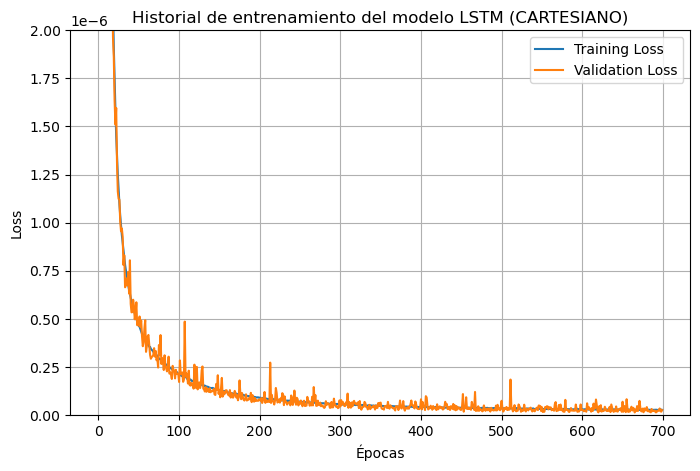

✅ Modelo LSTM (CARTESANO) listo para usar.


In [374]:
# Verificar si el modelo ya existe

LSTM_cart_model_path = "./2LPR/DD_NN_Pos/Modelos_NN/LSTM_cart/LSTM_nn_Best_Model.keras"
LSTM_cart_history_path = "./2LPR/DD_NN_Pos/Modelos_NN/LSTM_cart/lstm_best_history.json"

if os.path.exists(LSTM_cart_model_path):
    print("🔄 Cargando modelo LSTM (CARTESIANO) existente...")
    LSTM_cart_network = keras.models.load_model(LSTM_cart_model_path)
    LSTM_cart_network.summary()

    if os.path.exists(LSTM_cart_history_path):
        with open(LSTM_cart_history_path, "r") as f:
            LSTM_cart_history = json.load(f)
        with open(LSTM_cart_history_path, "r") as f:
            LSTM_cart_history = json.load(f)  # Load the history data as a dictionary
        # Create a dummy History object for plotting:
        #LSTM_cart_history = type('DummyHistory', (object,), {'history': LSTM_cart_history_dict})()

        # Graficar el history
        plt.figure(figsize=(8, 5))
        plt.plot(LSTM_cart_history["loss"], label="Training Loss")
        plt.plot(LSTM_cart_history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.gca().set_ylim(0, 2E-6)
        plt.title("Historial de entrenamiento del modelo LSTM (CARTESIANO)")
        plt.show()
    else:
        print("⚠️ No se encontró el archivo de history.")
else:
    print("⚙️ Creando nuevo modelo...")
    LSTM_cart_network = Sequential() #Sequential([Input(shape=(w_size, X_train_LSTM.shape[2]))])
    LSTM_cart_network.add(LSTM(10, activation='tanh', input_shape=(w_size, X_train_LSTM_cart.shape[2])))
    #LSTM_cart_network.add(LSTM(10, activation='tanh', dropout=0))
    LSTM_cart_network.add(Dense(y_train_LSTM_cart.shape[1]))
    LSTM_cart_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(1e-4), metrics = ['mae']) #learning_rate=1e-5
    LSTM_cart_network.summary()


    LSTM_checkpoint_cb_cart = keras.callbacks.ModelCheckpoint(LSTM_cart_model_path, save_best_only=True)
    LSTM_early_stopping_cb_cart = keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, 
                                                                min_delta=1E-10, restore_best_weights=True)

    LSTM_cart_history = LSTM_cart_network.fit(X_train_LSTM_cart, y_train_LSTM_cart, epochs=700, 
                                              batch_size=128, validation_data=(X_test_LSTM_cart, y_test_LSTM_cart), 
                                              callbacks=[LSTM_checkpoint_cb_cart, LSTM_early_stopping_cb_cart])    
    
    with open(LSTM_cart_history_path, "w") as f:
        json.dump(LSTM_cart_history.history, f)
    with open(LSTM_cart_history_path, "r") as f:
        LSTM_cart_history = json.load(f)  # Load the history data as a dictionary
    # Create a dummy History object for plotting:
    #LSTM_cart_history = type('DummyHistory', (object,), {'history': LSTM_cart_history_dict})()

    pd.DataFrame(LSTM_cart_history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 2e-6)
    plt.show()

print("✅ Modelo LSTM (CARTESANO) listo para usar.")

# Comparación de estimaciones

**Estimación de Dataset Joint**

In [375]:
#Estimación de Dataset Joint
#Uso el otro dataset joint

datos_2LRP_comp_joint = pd.read_csv(f'./2lpr_jointmovement_2024_12_01-18_04_07.csv', delimiter=',', 
                                    encoding="utf-8", skipinitialspace=True)

t_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,1].values

q1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:-2,2].values
q2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:-2,3].values

dq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:-2,4].values
dq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:-2,5].values

ddq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,6].values
ddq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,7].values

t1_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,8].values
t2_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,9].values

next_q1_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,2].values
next_q2_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,3].values
datos_2LRP_comp_joint.head()

ID   Time   Theta_1   Theta_2  D_Theta_1  D_Theta_2  DD_Theta_1  \
0   1  0.000 -1.926178 -1.430799   0.001258   0.004265    1.257762   
1   2  0.001 -1.926176 -1.430793   0.002516   0.008531    1.257762   
2   3  0.002 -1.926173 -1.430782   0.003773   0.012796    1.257762   
3   4  0.003 -1.926168 -1.430767   0.005031   0.017062    1.257762   
4   5  0.004 -1.926163 -1.430748   0.006289   0.021327    1.257762   

   DD_Theta_2  Torque_1  Torque_2  
0    4.265447 -2.000074 -0.890958  
1    4.265447 -1.999438 -0.888827  
2    4.265447 -1.998798 -0.886697  
3    4.265447 -1.998153 -0.884568  
4    4.265447 -1.997503 -0.882441

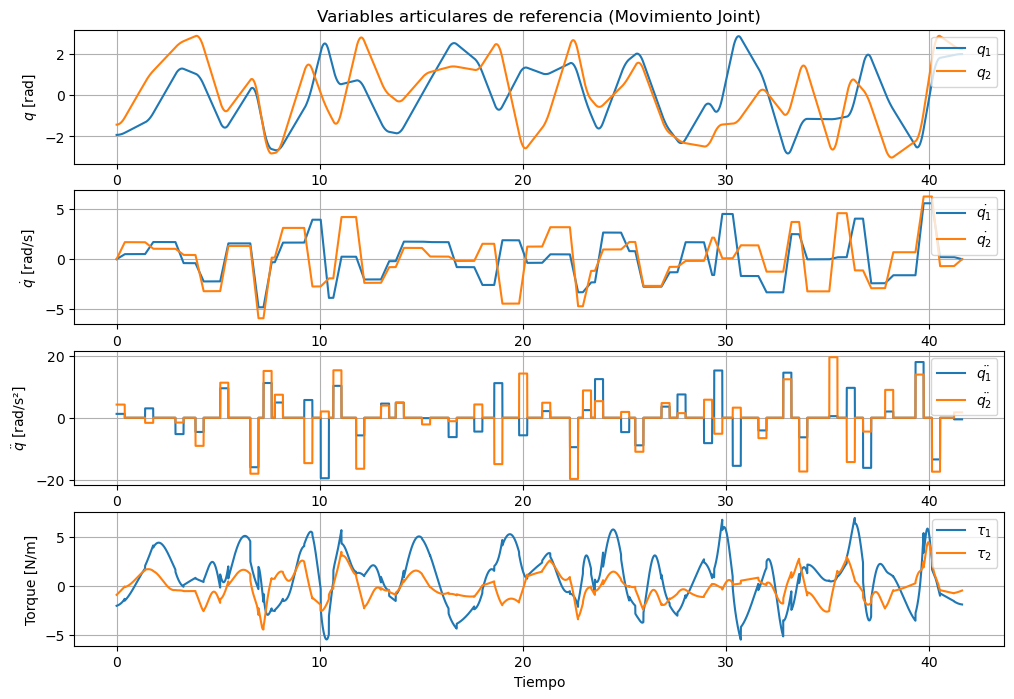

In [376]:
num_links = 2

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades
plt.subplot(4,1,1)
plt.plot(t_ref_comp_joint, q1_ref_comp_joint)
plt.plot(t_ref_comp_joint, q2_ref_comp_joint)
plt.legend([r'$q_1$', r'$q_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$q$ [rad]")
plt.grid(True)
plt.title('Variables articulares de referencia (Movimiento Joint)')
plt.subplot(4,1,2)
plt.plot(t_ref_comp_joint, dq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, dq2_ref_comp_joint)
plt.legend([r'$\dot{q_1}$', r'$\dot{q_2}$'],loc='upper right', fontsize=10);  plt.ylabel(r"$\dot{q}$ [rad/s]")
plt.grid(True)
plt.subplot(4,1,3)
plt.plot(t_ref_comp_joint, ddq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, ddq2_ref_comp_joint)
plt.legend([r'$\ddot{q_1}$', r'$\ddot{q_2}$'],loc='upper right', fontsize=10); plt.ylabel(r"$\ddot{q}$ [rad/s²]")
plt.grid(True)
plt.subplot(4,1,4)
plt.plot(t_ref_comp_joint, t1_ref_comp_joint)
plt.plot(t_ref_comp_joint, t2_ref_comp_joint)
plt.legend([r'$\tau_{1}$', r'$\tau_{2}$'],loc='upper right', fontsize=10); plt.xlabel('Tiempo'); plt.ylabel('Torque [N/m]')
plt.grid(True)
plt.show()

In [377]:
inputs_ref_comp_joint = np.vstack((q1_ref_comp_joint,q2_ref_comp_joint,t1_ref_comp_joint,t2_ref_comp_joint)).T
inputs_ref_comp_joint_LSTM = np.vstack((q1_ref_comp_joint,q2_ref_comp_joint,t1_ref_comp_joint,t2_ref_comp_joint)).T
outputs_ref_comp_joint = np.vstack((next_q1_ref_comp_joint,next_q2_ref_comp_joint)).T

In [378]:
#Primero con FF NN entrenada con Cartesianas
X_test_scaled_FF_NN_comp_joint_c = scaler1_FF_cart.transform(inputs_ref_comp_joint)
next_qs_sim_FF_NN_comp_joint_c = scaler2_FF_cart.inverse_transform(FF_NN_cart_network.predict(X_test_scaled_FF_NN_comp_joint_c))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step


In [379]:
#Primero con FF NN entrenada con Joint
X_test_scaled_FF_NN_comp_joint_j = scaler1_OSA.transform(inputs_ref_comp_joint)
next_qs_sim_FF_NN_comp_joint_j = scaler2_OSA.inverse_transform(FF_NN_network.predict(X_test_scaled_FF_NN_comp_joint_j))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step


In [380]:
#Con LSTM entrenada con Cartesianas
X_test_scaled_LSTM_comp_joint_c = scaler1_LSTM_cart.transform(inputs_ref_comp_joint_LSTM)
X_test_windowed_LSTM_comp_joint_c, t_ref_LSTM_comp_joint_c = create_sequences_with_time(X_test_scaled_LSTM_comp_joint_c, t_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_c
next_qs_sim_LSTM_comp_joint_c = scaler2_LSTM_cart.inverse_transform(LSTM_cart_network.predict(X_test_windowed_LSTM_comp_joint_c))
next_qs_sim_LSTM_comp_joint_c

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


array([[-1.9663532 , -0.04896997],
       [-1.9662987 , -0.04897414],
       [-1.9662428 , -0.04897783],
       ...,
       [ 1.6758382 ,  2.112454  ],
       [ 1.6758397 ,  2.1124449 ],
       [ 1.6758401 ,  2.1124372 ]], shape=(41566, 2), dtype=float32)

In [381]:
#Con LSTM entrenada con Joint
X_test_scaled_LSTM_comp_joint_j = scaler1_LSTM.transform(inputs_ref_comp_joint_LSTM)
X_test_windowed_LSTM_comp_joint_j, t_ref_LSTM_comp_joint_j = create_sequences_with_time(X_test_scaled_LSTM_comp_joint_j, t_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_j
next_qs_sim_LSTM_comp_joint_j = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM_comp_joint_j))

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


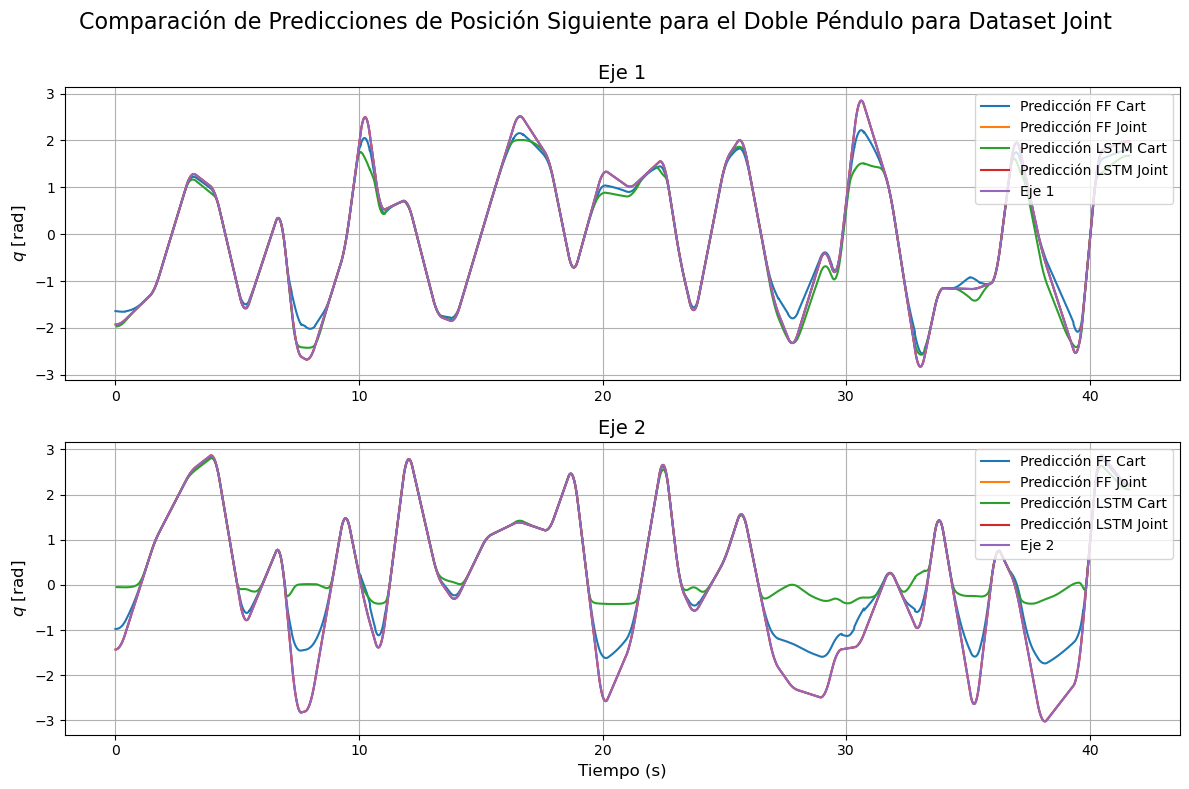

In [382]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Posición Siguiente para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_joint,next_qs_sim_FF_NN_comp_joint_c[:,i], label='Predicción FF Cart')
    plt.plot(t_ref_comp_joint,next_qs_sim_FF_NN_comp_joint_j[:,i], label='Predicción FF Joint')
    plt.plot(t_ref_LSTM_comp_joint_c,next_qs_sim_LSTM_comp_joint_c[:,i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_joint_j,next_qs_sim_LSTM_comp_joint_j[:,i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_joint,outputs_ref_comp_joint[:,i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel(r'$q$ [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()

0.0007238152090429788
0.00012534971533629128
0.0003854639251445398
0.00018146644902132457


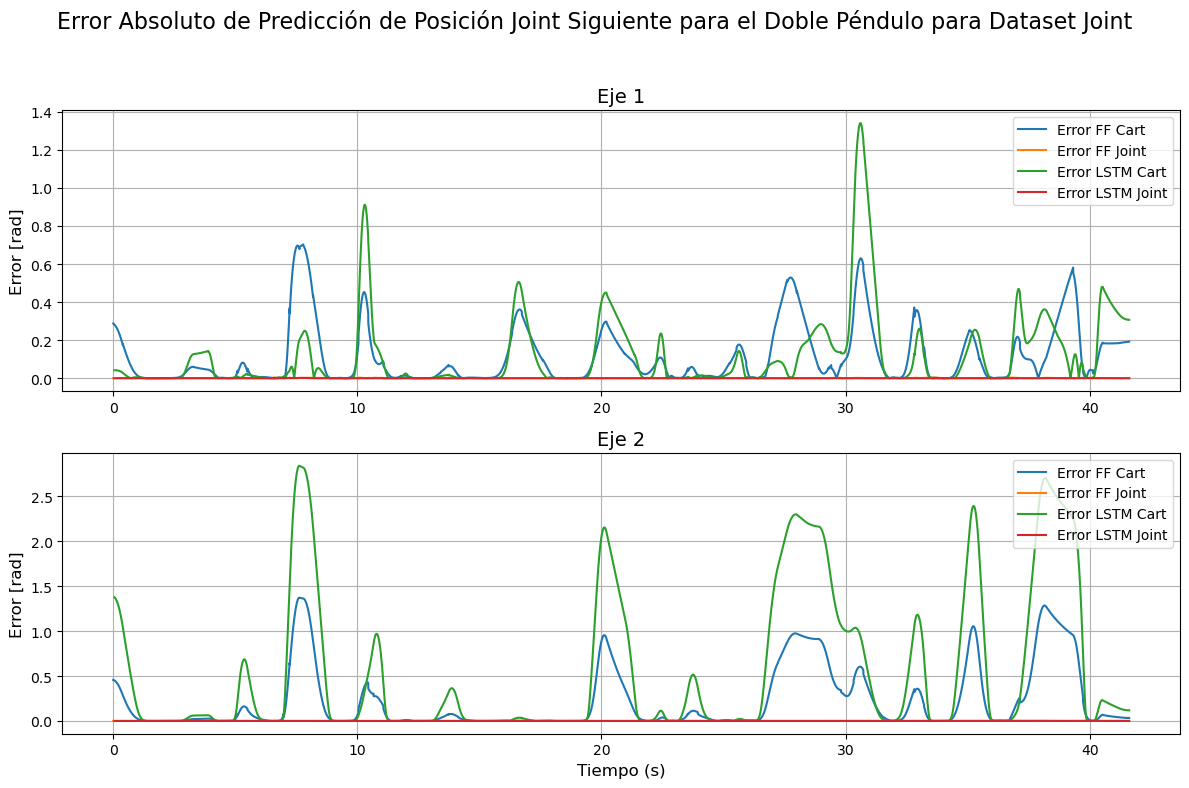

In [383]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error Absoluto de Predicción de Posición Joint Siguiente para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    error_OSA_Cart_j = np.sqrt((next_qs_sim_FF_NN_comp_joint_c[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_OSA_Joint_j = np.sqrt((next_qs_sim_FF_NN_comp_joint_j[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_LSTM_Cart_j = np.sqrt((next_qs_sim_LSTM_comp_joint_c[:, i] - outputs_ref_comp_joint[w_size:, i])**2)
    error_LSTM_Joint_j = np.sqrt((next_qs_sim_LSTM_comp_joint_j[:, i] - outputs_ref_comp_joint[w_size:, i])**2)
    
    #print(max(error_OSA_Cart_j))
    #print(max(error_OSA_Joint_j))
    #print(max(error_LSTM_Cart_j))
    #print(max(error_LSTM_Joint_j))
    print(np.mean(error_OSA_Joint_j))
    print(np.mean(error_LSTM_Joint_j))

    # Graficar los errores
    plt.plot(t_ref_comp_joint, error_OSA_Cart_j, label='Error FF Cart')
    plt.plot(t_ref_comp_joint, error_OSA_Joint_j, label='Error FF Joint')
    #plt.plot(t_ref_LSTM_comp_joint_c, error_LSTM_Cart_j, label='Error LSTM Cart')
    #plt.plot(t_ref_LSTM_comp_joint_j, error_LSTM_Joint_j, label='Error LSTM Joint')
    plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Cart_j, label='Error LSTM Cart')
    plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Joint_j, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


**Estimación de Dataset Cartesiano**

In [384]:
#Estimación de Dataset Cartesiano

datos_2LRP_comp_cart = pd.read_csv(f'./2lpr_cartesianmovement_2024_12_01-18_04_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

t_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,1].values

q1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:-2,2].values
q2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:-2,3].values

dq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:-2,4].values
dq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:-2,5].values

ddq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,6].values
ddq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,7].values

t1_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,8].values
t2_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,9].values

next_q1_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,2].values
next_q2_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,3].values

datos_2LRP_comp_cart.head()

ID   Time   Theta_1   Theta_2  D_Theta_1  D_Theta_2  DD_Theta_1  \
0   1  0.000 -1.174887  1.043499  -0.006224   0.011834   -4.149315   
1   2  0.001 -1.174893  1.043511  -0.010373   0.019723   -4.149118   
2   3  0.002 -1.174903  1.043531  -0.014523   0.027611   -4.148843   
3   4  0.003 -1.174918  1.043558  -0.018671   0.035499   -4.148489   
4   5  0.004 -1.174936  1.043594  -0.022820   0.043386   -4.148057   

   DD_Theta_2  Torque_1  Torque_2  
0    7.888932  2.095864  0.976848  
1    7.888525  2.093779  0.980795  
2    7.887955  2.091685  0.984743  
3    7.887223  2.089583  0.988693  
4    7.886328  2.087471  0.992643

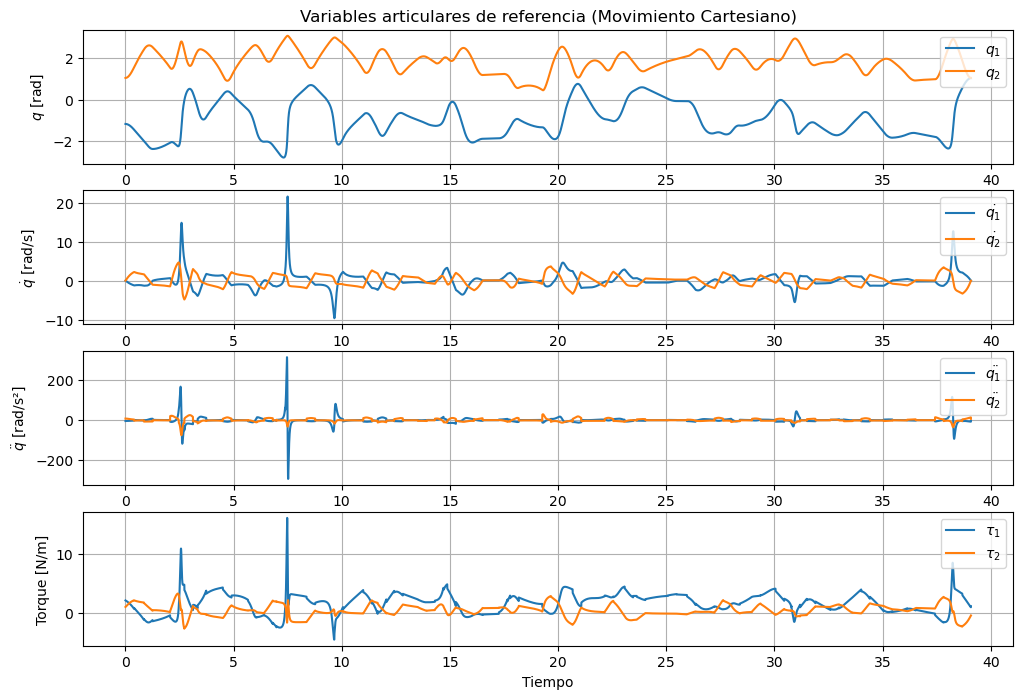

In [385]:
num_links = 2

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades
plt.subplot(4,1,1)
plt.plot(t_ref_comp_cart, q1_ref_comp_cart)
plt.plot(t_ref_comp_cart, q2_ref_comp_cart)
plt.legend([r'$q_1$', r'$q_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$q$ [rad]")
plt.grid(True)
plt.title('Variables articulares de referencia (Movimiento Cartesiano)')
plt.subplot(4,1,2)
plt.plot(t_ref_comp_cart, dq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, dq2_ref_comp_cart)
plt.legend([r'$\dot{q_1}$', r'$\dot{q_2}$'],loc='upper right', fontsize=10);  plt.ylabel(r"$\dot{q}$ [rad/s]")
plt.grid(True)
plt.subplot(4,1,3)
plt.plot(t_ref_comp_cart, ddq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, ddq2_ref_comp_cart)
plt.legend([r'$\ddot{q_1}$', r'$\ddot{q_2}$'],loc='upper right', fontsize=10); plt.ylabel(r"$\ddot{q}$ [rad/s²]")
plt.grid(True)
plt.subplot(4,1,4)
plt.plot(t_ref_comp_cart, t1_ref_comp_cart)
plt.plot(t_ref_comp_cart, t2_ref_comp_cart)
plt.legend([r'$\tau_{1}$', r'$\tau_{2}$'],loc='upper right', fontsize=10); plt.xlabel('Tiempo'); plt.ylabel('Torque [N/m]')
plt.grid(True)
plt.show()

In [386]:
inputs_ref_comp_cart = np.vstack((q1_ref_comp_cart,q2_ref_comp_cart,t1_ref_comp_cart,t2_ref_comp_cart)).T
inputs_ref_comp_cart_LSTM = np.vstack((q1_ref_comp_cart,q2_ref_comp_cart,t1_ref_comp_cart,t2_ref_comp_cart)).T
outputs_ref_comp_cart = np.vstack((next_q1_ref_comp_cart,next_q2_ref_comp_cart)).T

In [387]:
#Primero con FF NN entrenada con Cart

X_test_scaled_FF_NN_comp_cart_c = scaler1_FF_cart.transform(inputs_ref_comp_cart)
next_qs_sim_FF_NN_comp_cart_c = scaler2_FF_cart.inverse_transform(FF_NN_cart_network.predict(X_test_scaled_FF_NN_comp_cart_c))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step


In [388]:
#Primero con FF NN entrenada con Joint

X_test_scaled_FF_NN_comp_cart_j = scaler1_OSA.transform(inputs_ref_comp_cart)
next_qs_sim_FF_NN_comp_cart_j = scaler2_OSA.inverse_transform(FF_NN_network.predict(X_test_scaled_FF_NN_comp_cart_j))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step


In [389]:
#Con LSTM entrenada con Cart
X_test_scaled_LSTM_comp_cart_c = scaler1_LSTM_cart.transform(inputs_ref_comp_cart_LSTM)
X_test_windowed_LSTM_comp_cart_c, t_ref_LSTM_comp_cart_c = create_sequences_with_time(X_test_scaled_LSTM_comp_cart_c, t_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_c
next_qs_sim_LSTM_comp_cart_c = scaler2_LSTM_cart.inverse_transform(LSTM_cart_network.predict(X_test_windowed_LSTM_comp_cart_c))

1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [390]:
print(f"Longitud de data: {len(X_test_scaled_LSTM_comp_cart_c)}")
print(f"Longitud de time: {len(t_ref_comp_cart)}")
print(f"Tamaño de ventana: {w_size}")


Longitud de data: 39086
Longitud de time: 39086
Tamaño de ventana: 50


In [391]:
#Con LSTM entrenada con Joint
X_test_scaled_LSTM_comp_cart_j = scaler1_LSTM.transform(inputs_ref_comp_cart_LSTM)
X_test_windowed_LSTM_comp_cart_j, t_ref_LSTM_comp_cart_j = create_sequences_with_time(X_test_scaled_LSTM_comp_cart_j, t_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_j
next_qs_sim_LSTM_comp_cart_j = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM_comp_cart_j))

1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


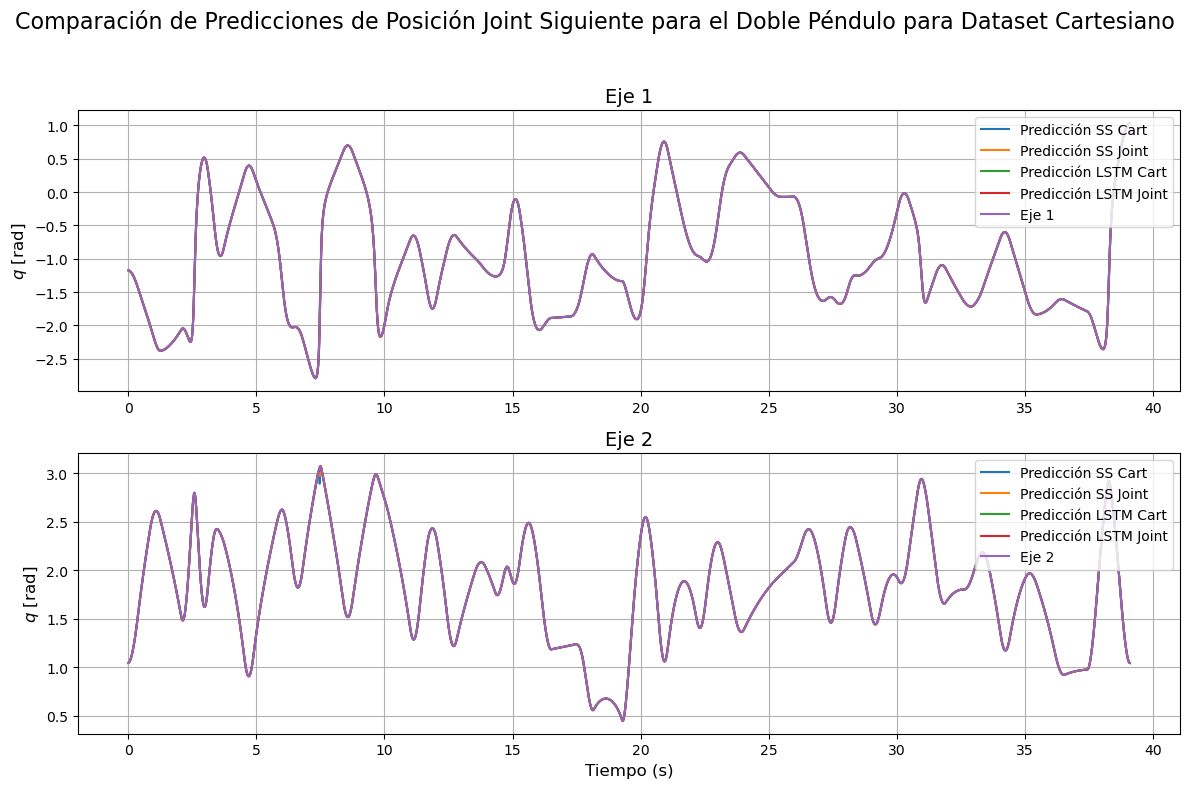

In [392]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Posición Joint Siguiente para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_cart, next_qs_sim_FF_NN_comp_cart_c[:, i], label='Predicción SS Cart')
    plt.plot(t_ref_comp_cart, next_qs_sim_FF_NN_comp_cart_j[:, i], label='Predicción SS Joint')
    plt.plot(t_ref_LSTM_comp_cart_c, next_qs_sim_LSTM_comp_cart_c[:, i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_cart_j, next_qs_sim_LSTM_comp_cart_j[:, i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_cart, outputs_ref_comp_cart[:, i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel(r'$q$ [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


0.0007745711169596506
0.00014549611649359792
0.0005944730011513194
0.00037861549880552136


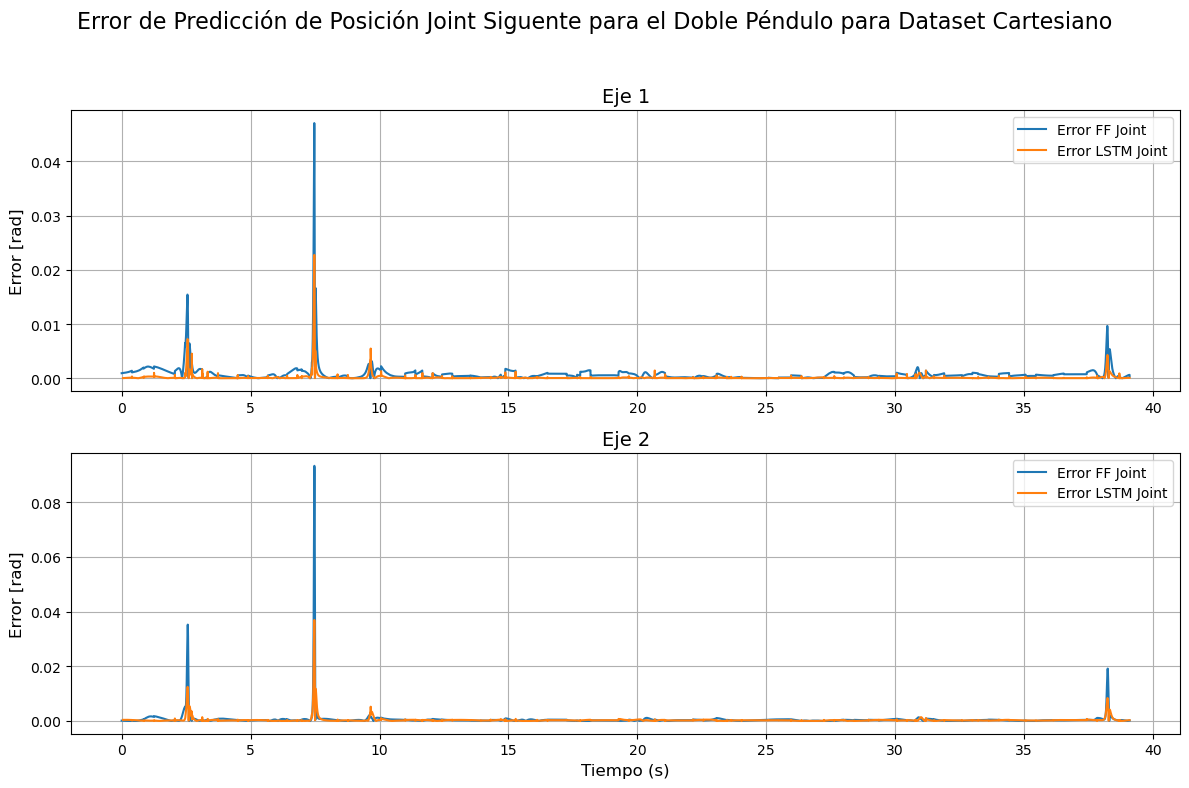

In [393]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Posición Joint Siguente para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    error_OSA_Cart_c = np.sqrt((next_qs_sim_FF_NN_comp_cart_c[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_OSA_Joint_c = np.sqrt((next_qs_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_LSTM_Cart_c = np.sqrt((next_qs_sim_LSTM_comp_cart_c[:, i] - outputs_ref_comp_cart[w_size:, i])**2)
    error_LSTM_Joint_c = np.sqrt((next_qs_sim_LSTM_comp_cart_j[:, i] - outputs_ref_comp_cart[w_size:, i])**2)

    #print(max(error_OSA_Cart_c))
    #print(max(error_OSA_Joint_c))
    #print(max(error_LSTM_Cart_c))
    #print(max(error_LSTM_Joint_c))
    print(np.mean(error_OSA_Joint_c))
    print(np.mean(error_LSTM_Joint_c))

    # Graficar los errores
    #plt.plot(t_ref_comp_cart, error_OSA_Cart_c, label='Error FF Cart')
    plt.plot(t_ref_comp_cart, error_OSA_Joint_c, label='Error FF Joint')
    #plt.plot(t_ref_comp_cart[w_size:], error_LSTM_Cart_c, label='Error LSTM Cart')
    plt.plot(t_ref_comp_cart[w_size:], error_LSTM_Joint_c, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


# **Análisis de Ruido**

Para las redes entrenadas con Joint, LSTM y FF, analizo la respuesta a ruido blanco gaussiano en la posición.

In [532]:
#datos_2LRP_comp_joint_noise = pd.read_csv(f'./2lpr_noise_jointmovement_2025-02-18.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
#datos_2LRP_comp_joint_noise = pd.read_csv(f'./2lpr_noise_jointmovement_2025-05-09.csv',delimiter=',', encoding="utf-8", skipinitialspace=True) #pos_noise_std=1e-8
#datos_2LRP_comp_joint_noise = pd.read_csv(f'./2lpr_noise_jointmovement_2025-05-14.csv',delimiter=',', encoding="utf-8", skipinitialspace=True) #pos_noise_std=1e-6
#datos_2LRP_comp_joint_noise = pd.read_csv(f'./2lpr_noise_jointmovement_2025_05_14-07_59_27.csv',delimiter=',', encoding="utf-8", skipinitialspace=True) #pos_noise_std=1e-4
datos_2LRP_comp_joint_noise = pd.read_csv(f'./2lpr_noise_jointmovement_2025_05_14-08_05_05.csv',delimiter=',', encoding="utf-8", skipinitialspace=True) #pos_noise_std=1e-3
std_level="1e-8"

t_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[1:-1,1].values

q1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:-2,2].values
q2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:-2,3].values

next_q1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:-2,2].values
next_q2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:-2,3].values

dq1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:-2,4].values
dq2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[:-2,5].values

ddq1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[1:-1,6].values
ddq2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[1:-1,7].values

t1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[1:-1,8].values
t2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[1:-1,9].values

next_q1_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[1:-1,2].values
next_q2_ref_comp_joint = datos_2LRP_comp_joint_noise.iloc[1:-1,3].values

q1_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[:-2,10].values
q2_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[:-2,11].values

next_q1_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[1:-1,10].values
next_q2_noise_comp_joint = datos_2LRP_comp_joint_noise.iloc[1:-1,11].values
datos_2LRP_comp_joint_noise.head()

ID   Time   Theta_1   Theta_2  D_Theta_1  D_Theta_2  DD_Theta_1  \
0   1  0.000 -2.853595 -0.976611   0.013751   0.007088   13.751415   
1   2  0.001 -2.853574 -0.976601   0.027503   0.014176   13.751415   
2   3  0.002 -2.853540 -0.976583   0.041254   0.021265   13.751415   
3   4  0.003 -2.853492 -0.976558   0.055006   0.028353   13.751415   
4   5  0.004 -2.853430 -0.976526   0.068757   0.035441   13.751415   

   DD_Theta_2  Torque_1  Torque_2  Theta_N_1  Theta_N_2  
0    7.088245 -2.651919 -0.369938  -2.853978  -0.975898  
1    7.088245 -2.645024 -0.366420  -2.852971  -0.976789  
2    7.088245 -2.638117 -0.362920  -2.853404  -0.976725  
3    7.088245 -2.631197 -0.359438  -2.854547  -0.977723  
4    7.088245 -2.624264 -0.355973  -2.853460  -0.976752

In [533]:
tau_ref_comp_joint = np.vstack((t1_ref_comp_joint,t2_ref_comp_joint)).T
dq_ref_comp_joint = np.vstack((dq1_ref_comp_joint,dq2_ref_comp_joint)).T
ddq_ref_comp_joint = np.vstack((ddq1_ref_comp_joint,ddq2_ref_comp_joint)).T
w_size = 50

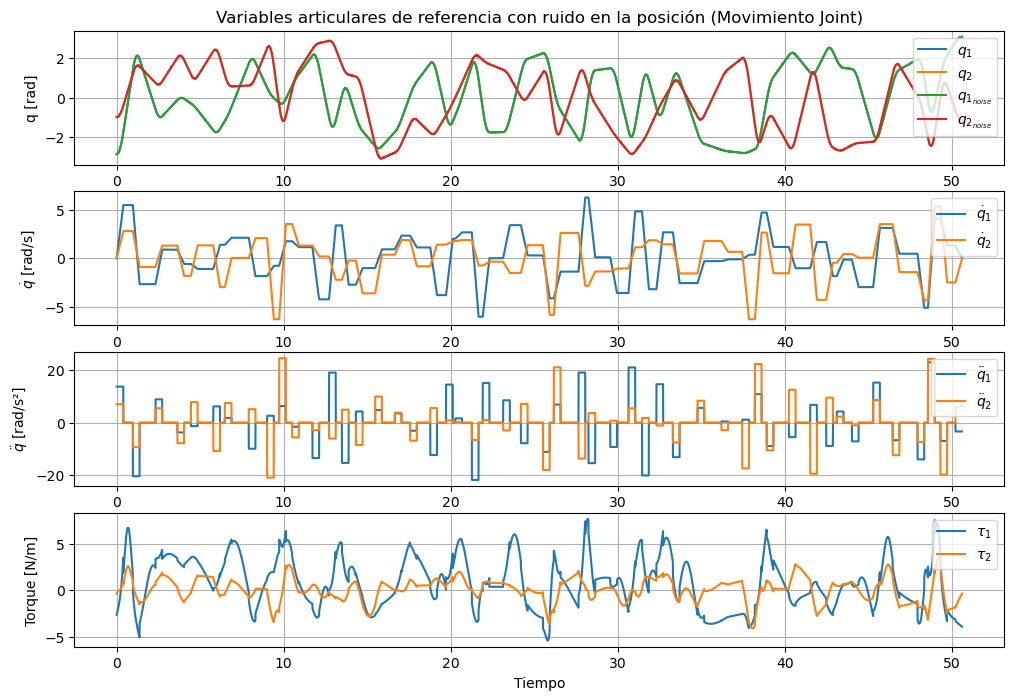

In [534]:
num_links = 2

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades
plt.subplot(4,1,1)
plt.plot(t_ref_comp_joint, q1_ref_comp_joint)
plt.plot(t_ref_comp_joint, q2_ref_comp_joint)
plt.plot(t_ref_comp_joint, q1_noise_comp_joint)
plt.plot(t_ref_comp_joint, q2_noise_comp_joint)
plt.legend([r'$q_1$', r'$q_2$', r'$q_{1_{noise}}$', r'$q_{2_{noise}}$'],loc='upper right', fontsize=10);  plt.ylabel('q [rad]')
plt.grid(True)
plt.title('Variables articulares de referencia con ruido en la posición (Movimiento Joint)')
plt.subplot(4,1,2)
plt.plot(t_ref_comp_joint, dq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, dq2_ref_comp_joint)
plt.legend([r'$\dot{q}_1$', r'$\dot{q}_2$'],loc='upper right', fontsize=10);  plt.ylabel(r'$\dot{q}$ [rad/s]')
plt.grid(True)
plt.subplot(4,1,3)
plt.plot(t_ref_comp_joint, ddq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, ddq2_ref_comp_joint)
plt.legend([r'$\ddot{q}_1$', r'$\ddot{q}_2$'],loc='upper right', fontsize=10);  plt.ylabel(r'$\ddot{q}$ [rad/s²]'); 
plt.grid(True)
plt.subplot(4,1,4)
plt.plot(t_ref_comp_joint, t1_ref_comp_joint)
plt.plot(t_ref_comp_joint, t2_ref_comp_joint)
plt.legend([r'$\tau_{1}$', r'$\tau_{2}$'],loc='upper right', fontsize=10); plt.xlabel('Tiempo'); plt.ylabel('Torque [N/m]')
plt.grid(True)
plt.show()

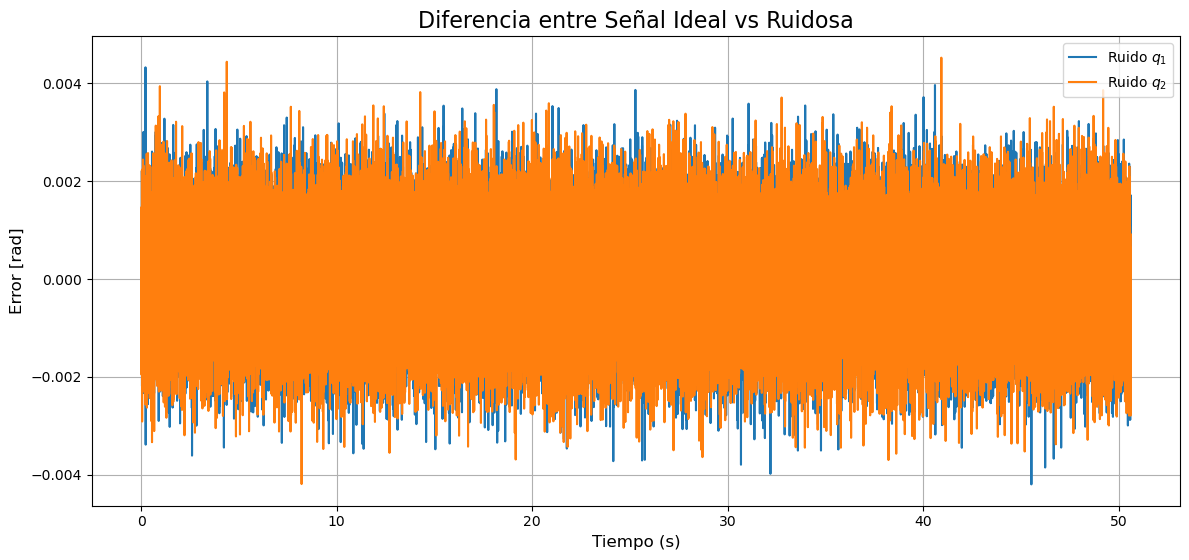

In [535]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.title("Diferencia entre Señal Ideal vs Ruidosa", fontsize=16)


noise_q1 =(q1_ref_comp_joint - q1_noise_comp_joint)
noise_q2 = (q2_ref_comp_joint - q2_noise_comp_joint)
noise = np.vstack((noise_q1, noise_q2)).T  # Ahora noise.shape == (N, 2)

# Graficar los errores
plt.plot(t_ref_comp_joint, noise_q1, label=f'Ruido $q_1$')
plt.plot(t_ref_comp_joint, noise_q2, label=f'Ruido $q_2$')


# Ajustar etiquetas y título del subplot
plt.ylabel('Error [rad]', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()

In [536]:
inputs_noise_comp_joint = np.vstack((q1_noise_comp_joint,q2_noise_comp_joint,t1_ref_comp_joint,t2_ref_comp_joint)).T
outputs_noise_comp_joint = np.vstack((next_q1_noise_comp_joint,next_q2_noise_comp_joint)).T
outputs_noise_comp_joint_2 = np.vstack((next_q1_ref_comp_joint,next_q2_ref_comp_joint)).T

In [537]:
#Primero con FF NN

X_noise_scaled_FF_NN = scaler1_OSA.transform(inputs_noise_comp_joint)
q_noise_FF_NN = scaler2_OSA.inverse_transform(FF_NN_network.predict(X_noise_scaled_FF_NN))

1581/1581 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [538]:
X_noise_scaled_LSTM = scaler1_LSTM.transform(inputs_noise_comp_joint)
X_noise_windowed_LSTM, t_noise_LSTM = create_sequences_with_time(X_noise_scaled_LSTM, t_ref_comp_joint)
q_noise_LSTM = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_noise_windowed_LSTM))

1580/1580 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


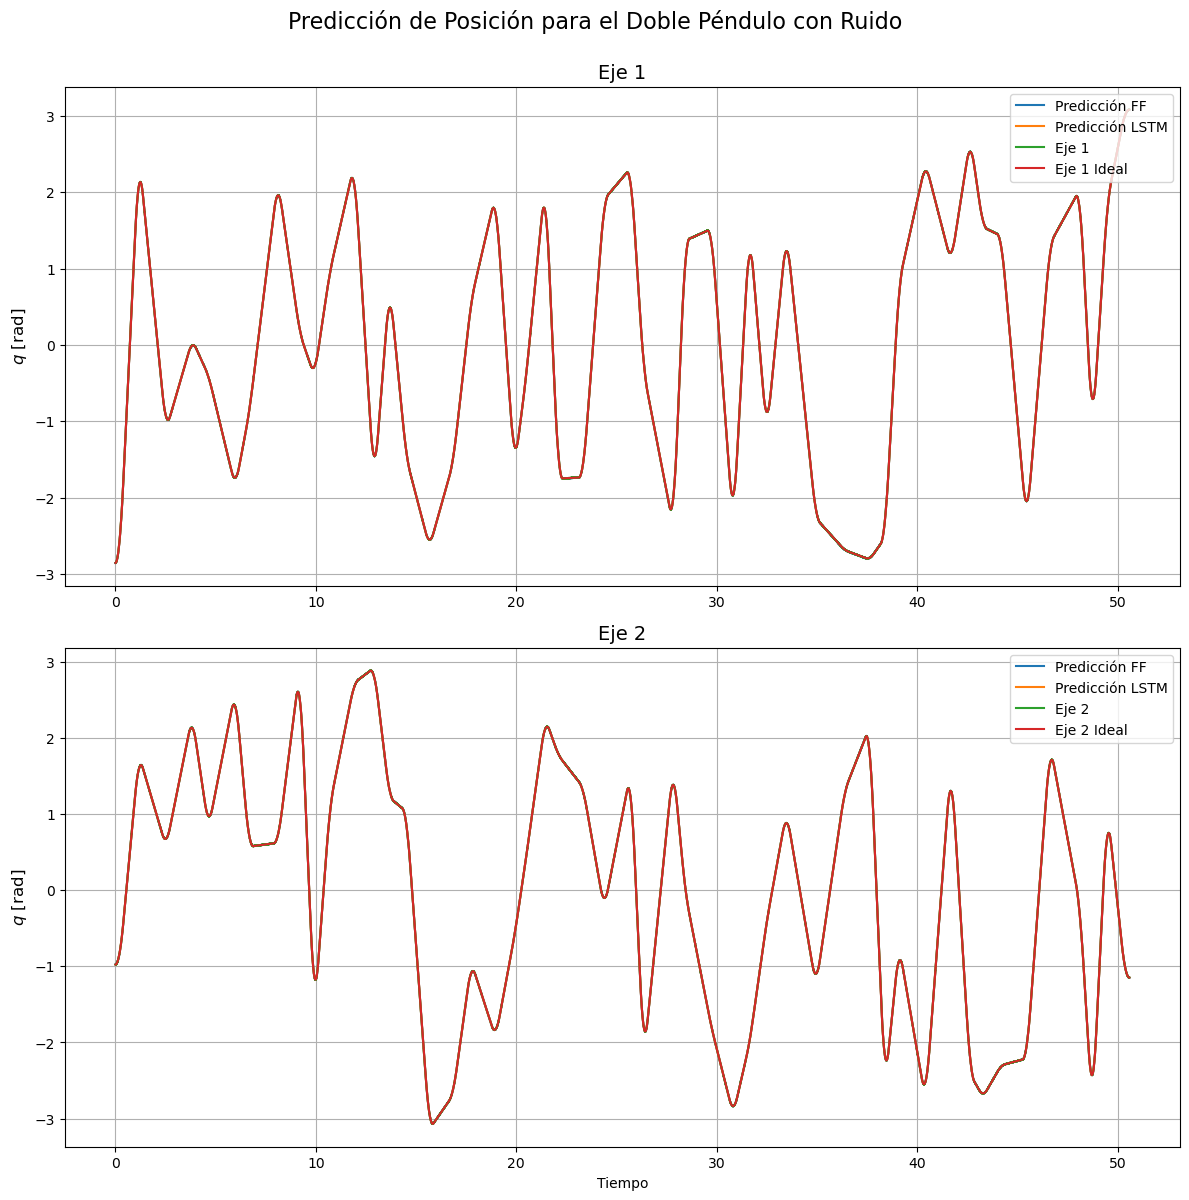

In [539]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Predicción de Posición para el Doble Péndulo con Ruido", fontsize=16)

# Grafico los resultados
for i in range(num_links):
  plt.subplot(num_links, 1, i+1)
  plt.plot(t_ref_comp_joint,q_noise_FF_NN[:,i])
  plt.plot(t_noise_LSTM,q_noise_LSTM[:,i])
  plt.plot(t_ref_comp_joint,outputs_noise_comp_joint[:,i])
  plt.plot(t_ref_comp_joint,outputs_noise_comp_joint_2[:,i])
  plt.ylabel(r'$q$ [rad]', fontsize=12)
  plt.legend(['Predicción FF', 'Predicción LSTM', f'Eje {i+1}', f'Eje {i+1} Ideal'],loc='upper right', fontsize=10)
  plt.title(f'Eje {i+1}', fontsize=14)
  plt.grid(True)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Dejar espacio para el título general
plt.xlabel('Tiempo');
plt.show()

Eje 1:
FF - MAE: 1.412672e-03, MSE: 3.215476e-06, R²: 0.9999985854
LSTM - MAE: 1.036819e-03, MSE: 1.721403e-06, R²: 0.9999992407
Eje 2:
FF - MAE: 1.194119e-03, MSE: 2.250892e-06, R²: 0.9999990773
LSTM - MAE: 1.051734e-03, MSE: 1.746559e-06, R²: 0.9999992845


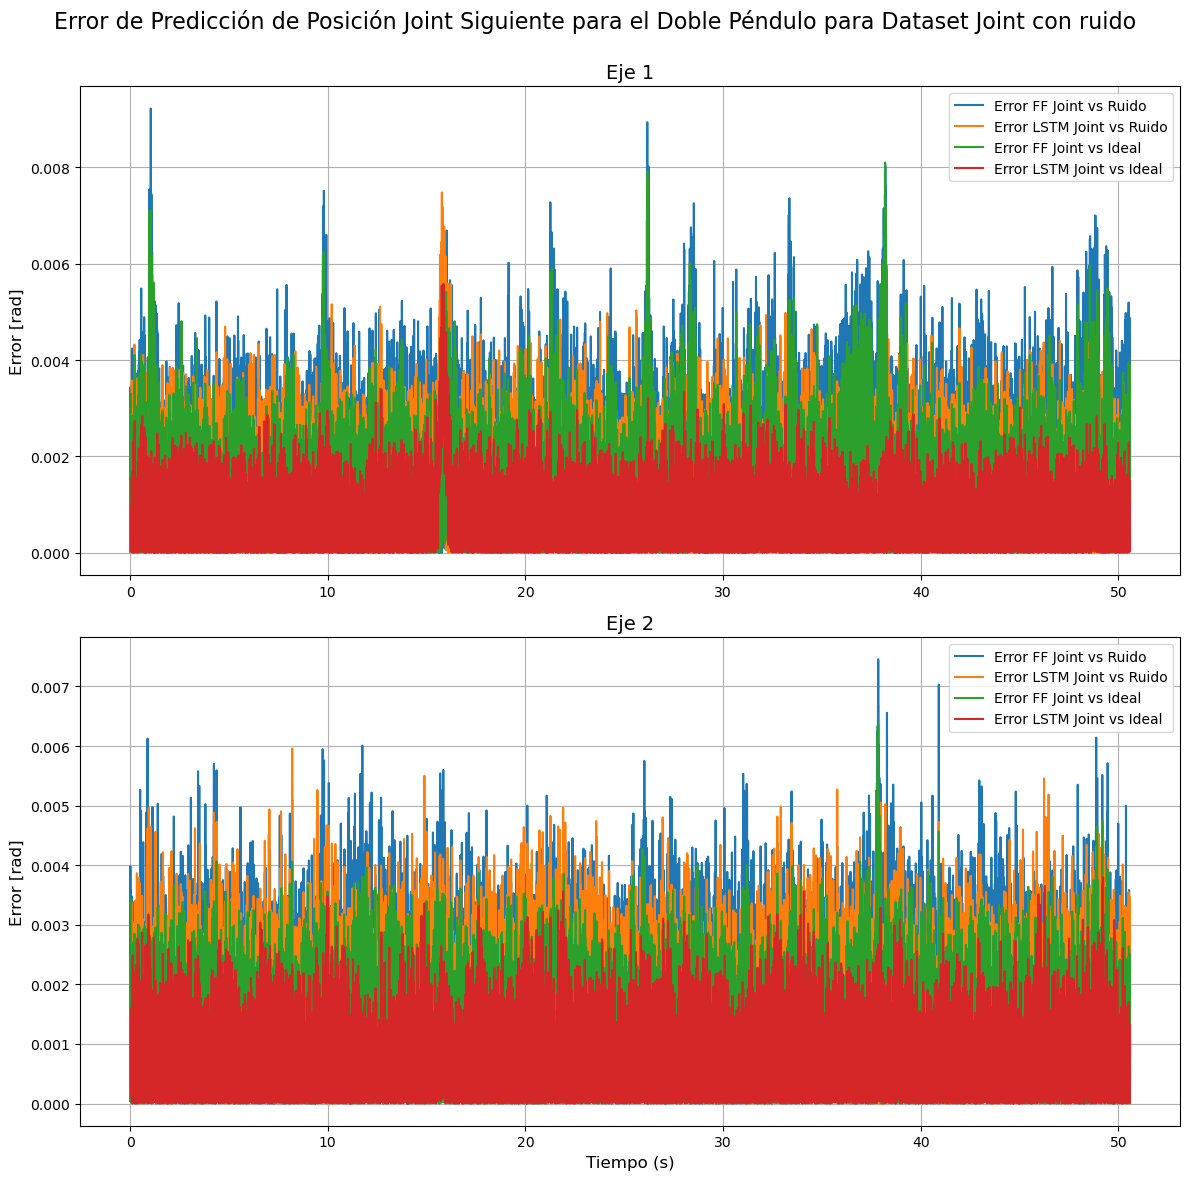

In [540]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Posición Joint Siguiente para el Doble Péndulo para Dataset Joint con ruido", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    error_OSA_Joint_j_noise = np.sqrt((q_noise_FF_NN[:, i] - outputs_noise_comp_joint[:, i])**2)
    error_LSTM_Joint_j_noise = np.sqrt((q_noise_LSTM[:, i] - outputs_noise_comp_joint[w_size:, i])**2)
    error_OSA_Joint_j_noise_2 = np.sqrt((q_noise_FF_NN[:, i] - outputs_noise_comp_joint_2[:, i])**2)
    error_LSTM_Joint_j_noise_2 = np.sqrt((q_noise_LSTM[:, i] - outputs_noise_comp_joint_2[w_size:, i])**2)
    # Para eje i (por ejemplo, eje 0 o 1)
    y_true = outputs_noise_comp_joint[:, i]             # Señal real con ruido
    y_pred_ff = q_noise_FF_NN[:, i]                     # Predicción FF
    y_pred_lstm = q_noise_LSTM[:, i]                    # Predicción LSTM

    # MAE
    mae_ff = mean_absolute_error(y_true, y_pred_ff)
    mae_lstm = mean_absolute_error(y_true[w_size:], y_pred_lstm)

    # MSE
    mse_ff = mean_squared_error(y_true, y_pred_ff)
    mse_lstm = mean_squared_error(y_true[w_size:], y_pred_lstm)

    # R²
    r2_ff = r2_score(y_true, y_pred_ff)
    r2_lstm = r2_score(y_true[w_size:], y_pred_lstm)

    # Imprimir resultados
    print(f"Eje {i+1}:")
    print(f"FF - MAE: {mae_ff:.6e}, MSE: {mse_ff:.6e}, R²: {r2_ff:.10f}")
    print(f"LSTM - MAE: {mae_lstm:.6e}, MSE: {mse_lstm:.6e}, R²: {r2_lstm:.10f}")

    #error_OSA_Joint_j_noise = (q_noise_FF_NN[:, i] - outputs_noise_comp_joint[:, i])
    #error_LSTM_Joint_j_noise = (q_noise_LSTM[:, i] - outputs_noise_comp_joint[w_size:, i])
    #error_OSA_Joint_j_noise_2 = (q_noise_FF_NN[:, i] - outputs_noise_comp_joint_2[:, i])
    #error_LSTM_Joint_j_noise_2 = (q_noise_LSTM[:, i] - outputs_noise_comp_joint_2[w_size:, i])
    
    
    # Graficar los errores
    plt.plot(t_ref_comp_joint, error_OSA_Joint_j_noise, label='Error FF Joint vs Ruido')
    plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Joint_j_noise, label='Error LSTM Joint vs Ruido')
    plt.plot(t_ref_comp_joint, error_OSA_Joint_j_noise_2, label='Error FF Joint vs Ideal')
    plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Joint_j_noise_2, label='Error LSTM Joint vs Ideal')
    #plt.plot(t_ref_comp_joint, noise[:,i], label='Ruido')

    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()

**Tengo que calcular veociades y aceleraciones en base a las muestras ruidosas**

In [548]:
qd_noise_spline, qdd_noise_spline = reconstruir_dinamica(t_noise_LSTM, q_noise_LSTM, metodo="spline",sigma=30)
qd_noise_diff, qdd_noise_diff = reconstruir_dinamica(t_noise_LSTM, q_noise_LSTM, metodo="diferencias",sigma=30)

In [549]:
5e-2

0.05

In [550]:
t_ref_comp_joint[49]

np.float64(0.0500009883962282)

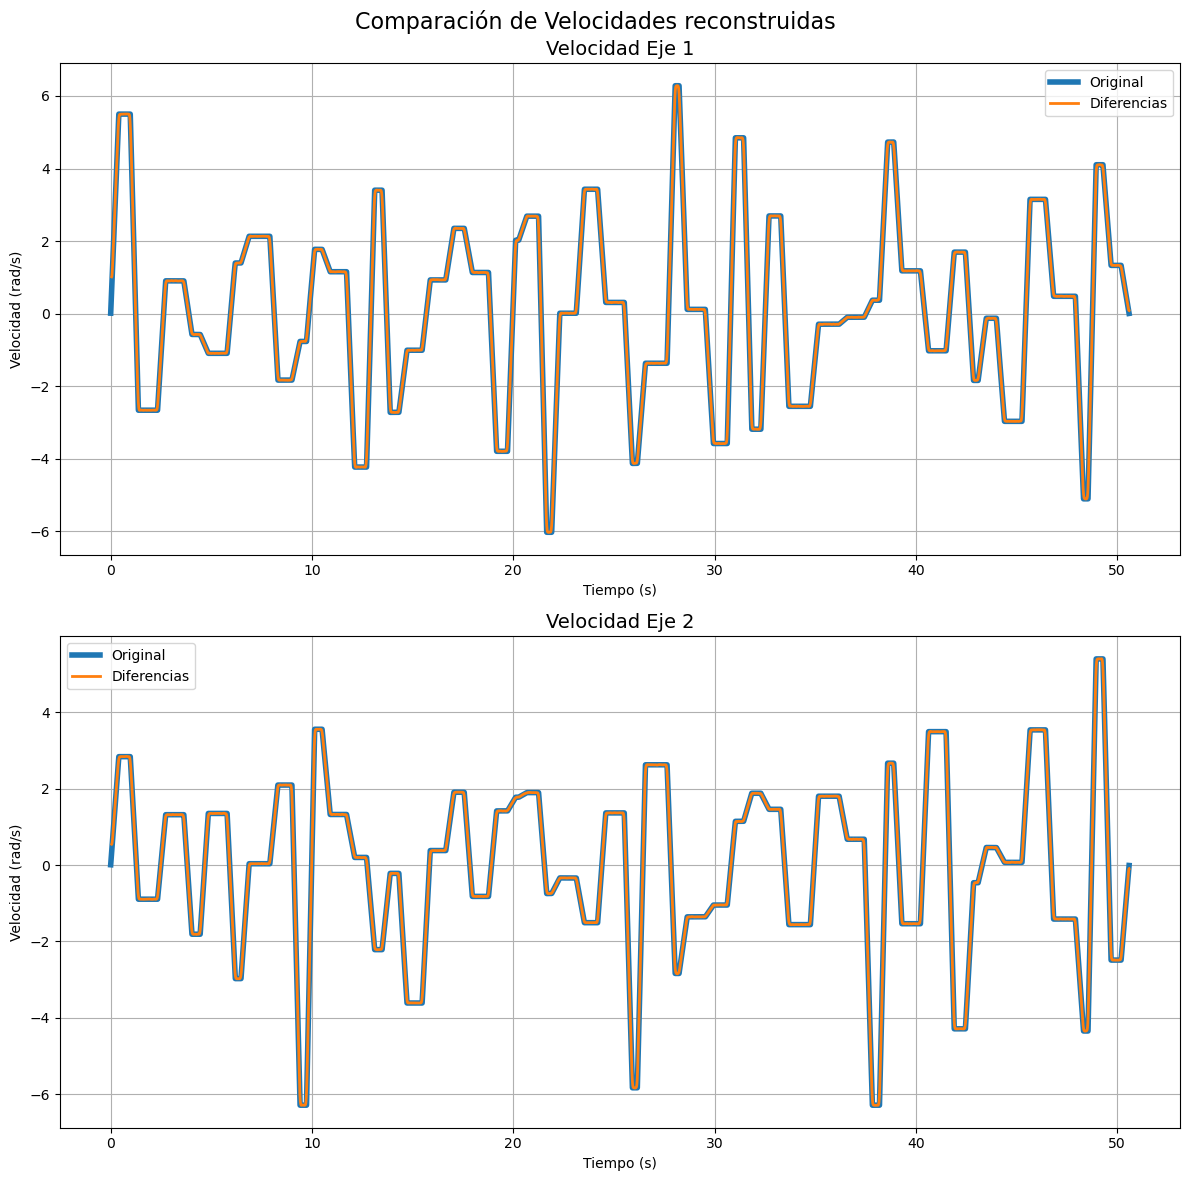

In [551]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Velocidades reconstruidas", fontsize=16)

for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)


# Aceleración - Comparación spline vs diferencias
    plt.plot(t_ref_comp_joint, dq_ref_comp_joint[:,i], label="Original", linewidth=4)
    #plt.plot(t_noise_LSTM, qd_noise_spline[:,i], label="Spline", linewidth=2)
    plt.plot(t_noise_LSTM[:], qd_noise_diff[:,i], label="Diferencias", linewidth=2)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Velocidad (rad/s)")
    plt.title(f'Velocidad Eje {i+1}', fontsize=14)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

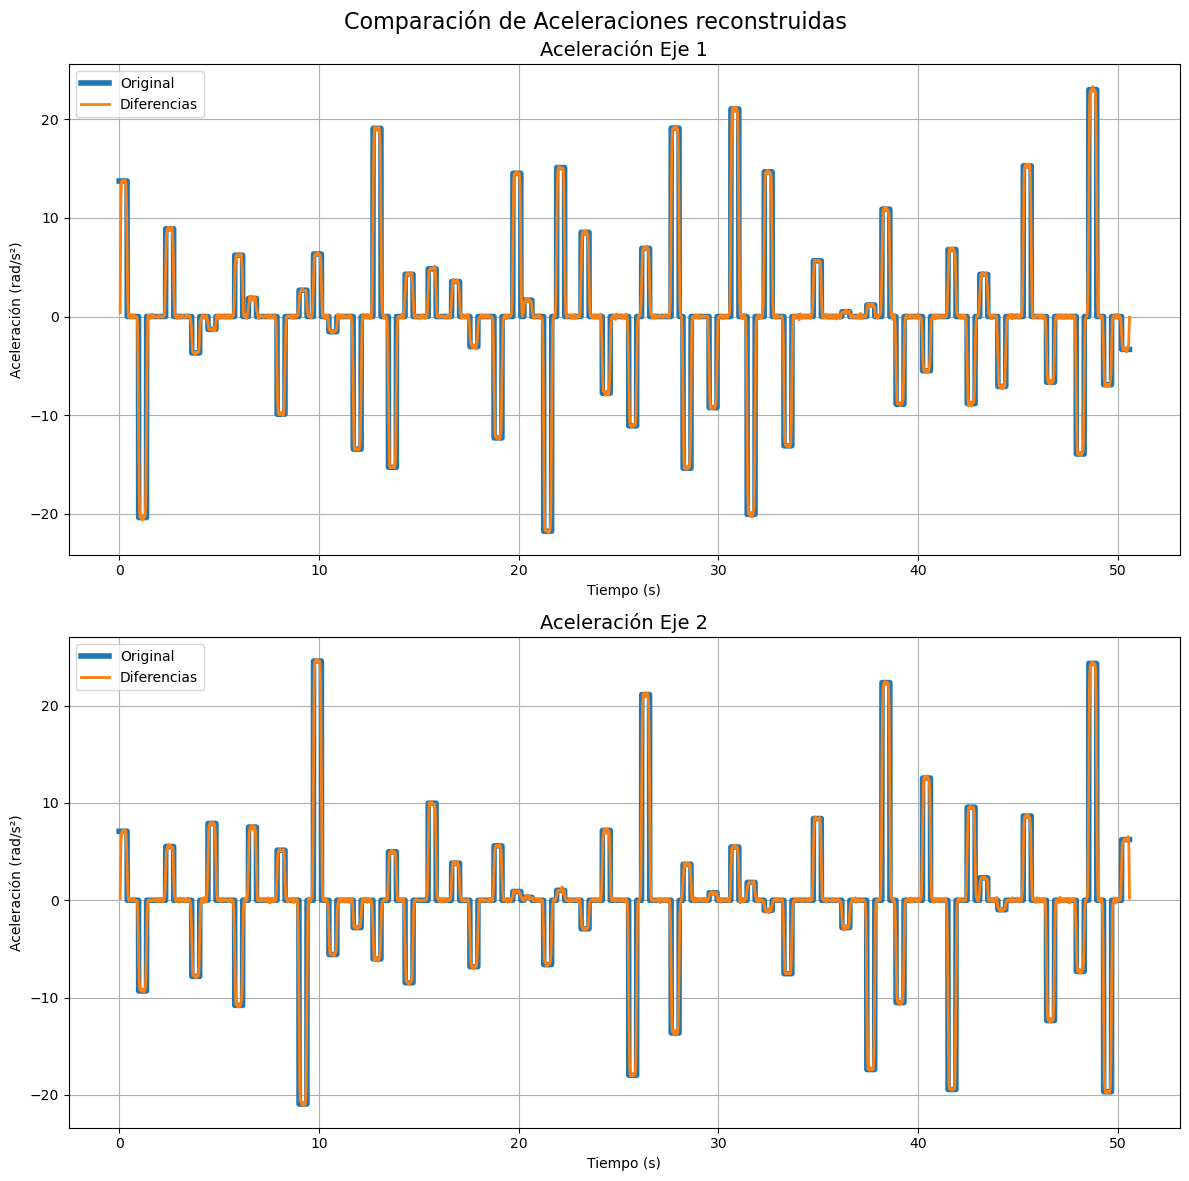

In [552]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Aceleraciones reconstruidas", fontsize=16)

for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)


# Aceleración - Comparación spline vs diferencias
    plt.plot(t_ref_comp_joint, ddq_ref_comp_joint[:,i], label="Original", linewidth=4)
    #plt.plot(t_noise_LSTM, qdd_noise_spline[:,i], label="Spline", linewidth=2)
    plt.plot(t_noise_LSTM[:], qdd_noise_diff[:,i], label="Diferencias", linewidth=2)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Aceleración (rad/s²)")
    plt.title(f'Aceleración Eje {i+1}', fontsize=14)
    plt.legend()
    plt.grid()


plt.tight_layout()
plt.show()

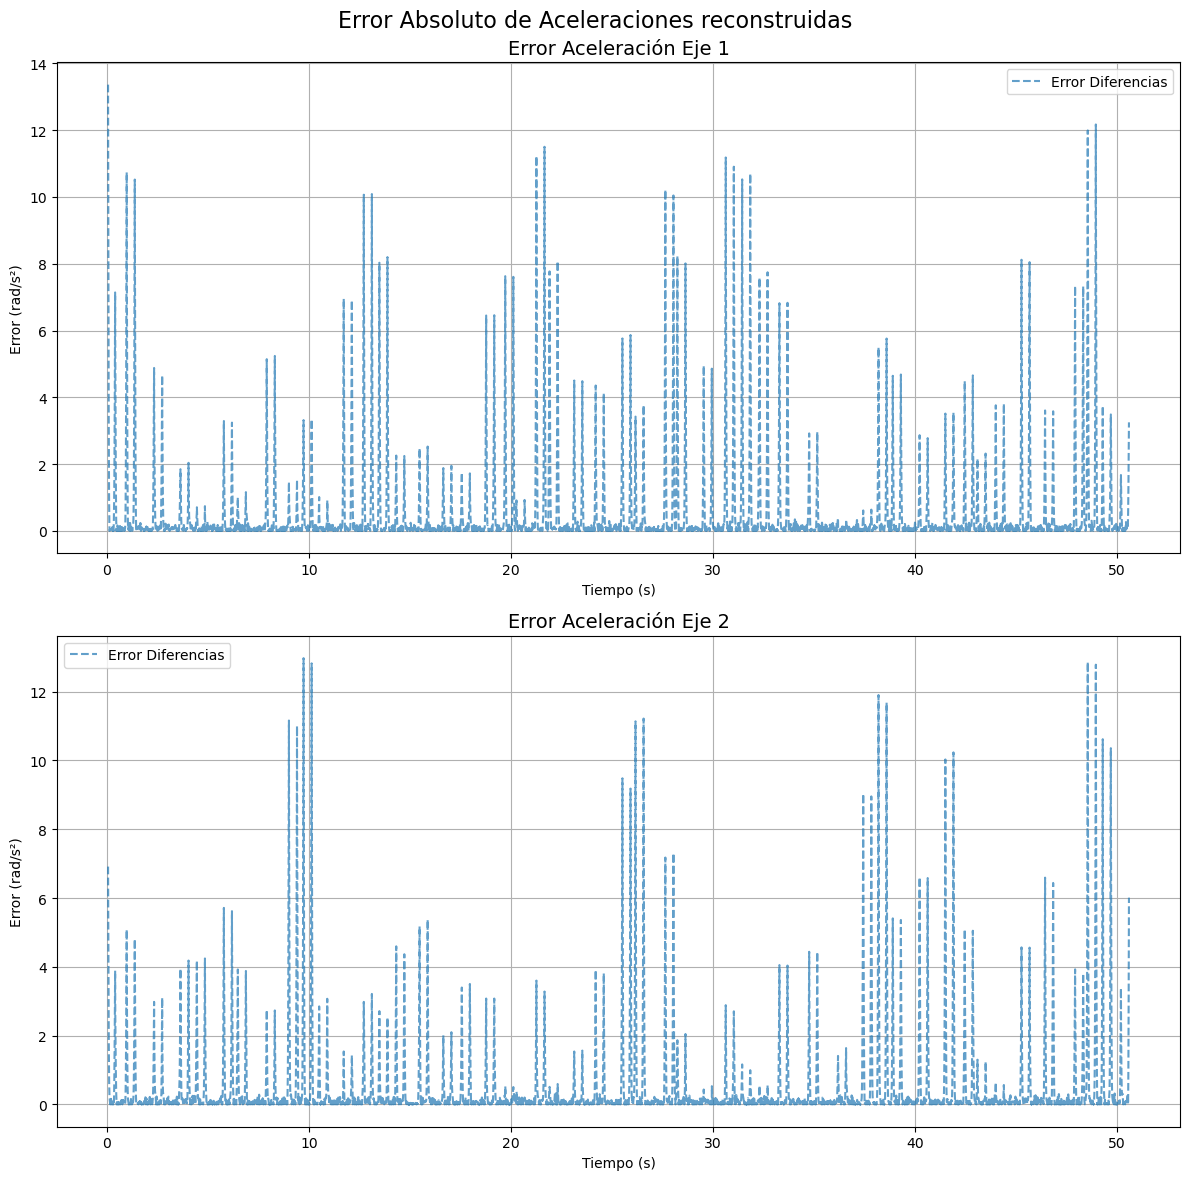

In [553]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error Absoluto de Aceleraciones reconstruidas", fontsize=16)

for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    # Calcular el error absoluto
    #error_spline = np.abs(ddq_ref_comp_joint[w_size:, i] - qdd_noise_spline[:, i])
    error_diff = np.abs(ddq_ref_comp_joint[w_size-2:-2, i] - qdd_noise_diff[:, i])

    # Graficar los errores
    #plt.plot(t_noise_LSTM, error_spline, label="Error Spline", linewidth=2)
    plt.plot(t_noise_LSTM, error_diff, linestyle="dashed", label="Error Diferencias", alpha=0.7)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Error (rad/s²)")
    plt.title(f'Error Aceleración Eje {i+1}', fontsize=14)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [554]:
#file_name = f'Reconstruccion_2lpr_jointmovement_{std_level}'
#write_noise_data_to_csv(file_name, t_noise_LSTM, outputs_noise_comp_joint_2, dq_ref_comp_joint, ddq_ref_comp_joint, tau_ref_comp_joint, q_noise_LSTM, qd_noise_spline, qdd_noise_spline)